In [46]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
import datetime
from tqdm import tqdm
import random
import statsmodels.api as sm

mpl.rc('font', family='Malgun Gothic')

In [2]:
# generate dataframe
df_member = pd.read_csv('./Member_Data.csv', encoding='cp949')
df_member = df_member.drop(columns='Unnamed: 0')

df_product = pd.read_csv('./Product_Data.csv', encoding='utf-8')

df_sales = pd.read_csv('./Sales_Data05.csv', encoding='utf-8')

In [3]:
df_member.head()

,회원번호,회원상태,성별,나이,등록카드,결혼,구독여부,주소지,세부주소지
0,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구
1,18792000,정상회원,남,83,연결앱결제,NaN,False,강원도,강릉시
2,18942336,정상회원,여,39,신한은행,기혼,False,인천광역시,중구
3,18949760,정상회원,여,73,기업은행,NaN,NaN,강원도,홍천군
4,19391488,정상회원,여,52,연결앱결제,기혼,False,대전광역시,중구


In [4]:
df_product.head()

,제품번호,물품명,물품대분류,물품중분류,상품중량
0,100021V2_0,2단무늬컵,식기/편백,자기,1p
1,100022V2_1,7곡딸기롤과자,과자,스낵,100g/10개입
2,100023V2_2,7곡참식,식사대용,선식/생식,700g
3,100024V2_3,가리비,생물수산,패류/갑각류,1.5kg
4,100025V2_3,가리비,생물수산,패류/갑각류,1kg


In [5]:
df_sales.head()

,회원번호,회원상태,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,주문시간,제품번호
0,1032097472,정상회원,1.0,7083,2021-01-02,NaN,NaN,0,0,주문취소,오후 12:60,100021783V2_1337
1,1032097472,정상회원,1.0,29865,2021-01-02,2021-01-02,2021-01-02,0,0,NaN,오후 12:60,100022137V2_1606
2,1032097472,정상회원,1.0,23164,2021-01-02,2021-01-02,2021-01-03,0,0,NaN,오후 12:60,100021452V2_1113
3,369152832,정상회원,1.0,16655,2021-01-02,2021-01-02,2021-01-03,0,0,NaN,오후 12:60,10002931V2_708
4,1032097472,정상회원,1.0,8423,2021-01-02,NaN,NaN,0,0,주문취소,오후 12:60,100022085V2_1559


## 고객 이탈률
df_member 에서 회원 상태로 정상회원과 탈퇴회원 파악 가능

고객 이탈률(%) = ( 탈퇴회원 수 / 전체 회원 수 ) * 100

In [6]:
df_member['회원상태'].value_counts(dropna=False)

회원상태
정상회원     12380
탈퇴         156
탈퇴처리중        2
NaN          1
탈퇴신청         1
Name: count, dtype: int64

In [7]:
# 탈퇴 회원 수
cond_withdraw = (df_member['회원상태'] != '정상회원')
withdraw = len(df_member.loc[cond_withdraw])

# 고객 이탈률 계신 탈퇴 회원 수
cond_withdraw = (df_member['회원상태'] != '정상회원')
withdraw = len(df_member.loc[cond_withdraw])

# 고객 이탈률 계신
withdraw_rate = (withdraw / len(df_member)) * 100
print(f"고객 이탈률(%): {np.round(withdraw_rate, 3)}%")

# 고객 이탈률은 1.276%로 크게 높다고 생각이 들지는 않음. 고객 이탈률을 유의미하게 줄이기보다
# 다양한 마케팅 전략을 시도하면서 고객 이탈률을 유지하거나 10% 내외로 변동하게 유지하는 것이 중요하다고 판단

# 탈퇴 회원의 특징은 무엇인지 그들의 df_sales에서 확인해봐도 좋을 듯!!!

고객 이탈률(%): 1.276%


## 구매주기 n개월 이하 고객 비율
df_sales에서 각 고객별로 주문 내역을 monthly로 살펴본 뒤, 구매주기가 n개월 이하인 고객 파악

n개월 구매주기 고객 비율(%) = ( n개월 구매주기 고객 수 / 전체 고객 수 ) * 100


In [8]:
# to_datetime
df_sales[['주문일시',
          '배송시작일',
          '배송완료일']] = df_sales[['주문일시', '배송시작일', '배송완료일']].apply(pd.to_datetime)

In [9]:
# check sales of each member according to orderdate
memberwise_sales = df_sales.groupby(['회원번호','주문일시']).count().reset_index()
memberwise_sales

,회원번호,주문일시,회원상태,구매수량,구매금액,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,주문시간,제품번호
0,18764160,2021-01-03,2,2,2,2,2,2,2,0,2,2
1,18764160,2021-01-23,3,3,3,3,3,3,3,0,3,3
2,18764160,2021-03-30,2,2,2,2,2,2,2,0,2,2
3,18764160,2021-04-11,1,1,1,1,1,1,1,0,1,1
4,18764160,2021-04-14,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
193289,1670620864,2021-04-27,1,1,1,1,1,1,1,0,1,1
193290,1670620864,2021-04-28,8,8,8,8,8,8,8,0,8,8
193291,1670620864,2021-04-30,2,2,2,2,2,2,2,0,2,2
193292,1670620864,2021-06-02,2,2,2,2,2,2,2,0,2,2


In [10]:
def isloyal(member_list, memberwise_sales, gap):
    a = []
    b = []
    col_name = ['회원번호', 'count']
    
    # 멤버 한 명씩 주문 일시를 살펴볼 때,
    for member in member_list:
        target_member = memberwise_sales[memberwise_sales['회원번호'] == member].sort_values(by='주문일시')
        count = 0  # 멤버마다 구매유지를 하지 못한 횟수
        
        # 특정 타겟 멤버의 주문 내역을 순회
        for i in range(len(target_member) - 1):
            sales_gap = (target_member['주문일시'].iloc[i+1] - target_member['주문일시'].iloc[i])
            if sales_gap > gap:
                count += 1

        a.append(member)
        b.append(count)

    list_df = pd.DataFrame({'회원번호': a, 'count': b})
    
    return list_df

In [11]:
# 구매유지의 기준이 되는 timedelta
gap = datetime.timedelta(days=120)

# 실행
result = isloyal(memberwise_sales['회원번호'].unique(), memberwise_sales, gap)
print(result)

             회원번호  count
0        18764160      0
1        18792000      0
2        18942336      0
3        18949760      0
4        19391488      0
...           ...    ...
12535  1644957952      0
12536  1645334720      0
12537  1670400000      0
12538  1670606016      1
12539  1670620864      0

[12540 rows x 2 columns]


In [12]:
result['count'].value_counts()

count
0    11274
1     1262
2        4
Name: count, dtype: int64

In [13]:
# 장기고객의 기준이 되는 count는 임의로 1번이내로 설정. gap 값 변화해가면서 살펴볼 것!!!
print(f"장기고객비율: {result['count'].value_counts()[0] / 12540}")

장기고객비율: 0.899043062200957


## 배송 지연률
해당 기업이 식품을 당일 배송해주는 시스템으로 구성되었으므로, 배송 지연의 기준 일자는 2일로 설정

주문일시와 배송완료 2일일 이상 차이나는 경우를 배송지연이라정의

, 배송 지연율(%) = ( 배송지연 발생 건 / 전체 주문 건 ) * 100

In [14]:
# 멤버별로 배송시작일과 배송완료일
memberwise_delivery = df_sales.groupby(['회원번호','주문일시','배송시작일','배송완료일']).count().reset_index()
memberwise_delivery

,회원번호,주문일시,배송시작일,배송완료일,회원상태,구매수량,구매금액,사용 적립금,사용 포인트 네이버,주문취소여부,주문시간,제품번호
0,18764160,2021-01-03,2021-01-03,2021-01-03,1,1,1,1,1,0,1,1
1,18764160,2021-01-03,2021-01-05,2021-01-06,1,1,1,1,1,0,1,1
2,18764160,2021-01-23,2021-01-23,2021-01-25,1,1,1,1,1,0,1,1
3,18764160,2021-01-23,2021-01-24,2021-01-25,1,1,1,1,1,0,1,1
4,18764160,2021-01-23,2021-01-24,2021-01-26,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
424684,1670620864,2021-04-30,2021-04-30,2021-04-30,1,1,1,1,1,0,1,1
424685,1670620864,2021-04-30,2021-04-30,2021-05-01,1,1,1,1,1,0,1,1
424686,1670620864,2021-06-02,2021-06-02,2021-06-03,1,1,1,1,1,0,1,1
424687,1670620864,2021-06-02,2021-06-02,2021-06-04,1,1,1,1,1,0,1,1


In [15]:
def late_delivery(member_list, memberwise_sales, deli_gap):
    a = []
    b = []
    col_name = ['회원번호', 'delivery_count']
    
    # 멤버 한 명씩 주문 일시를 살펴볼 때,
    for member in member_list:
        target_member = memberwise_sales[memberwise_sales['회원번호'] == member].sort_values(by='주문일시')
        delivery_count = 0  # 멤버마다 배송지연이 발생한 횟수
        
        # 특정 타겟 멤버의 주문 내역을 순회
        for i in range(len(target_member)):
            delivery_gap = (target_member['배송완료일'].iloc[i] - target_member['주문일시'].iloc[i])
            if delivery_gap > deli_gap:
                delivery_count += 1

        a.append(member)
        b.append(delivery_count)

    list_df = pd.DataFrame({'회원번호': a, 'delivery_count': b})
    
    return list_df

In [16]:
# 배송지연의 기준이 되는 timedelta (2일)
deli_gap = datetime.timedelta(days=2)

# 실행
deli_result = late_delivery(memberwise_sales['회원번호'].unique(), memberwise_delivery, deli_gap)
print(deli_result)

             회원번호  delivery_count
0        18764160               4
1        18792000               0
2        18942336               6
3        18949760               0
4        19391488               0
...           ...             ...
12535  1644957952               1
12536  1645334720               0
12537  1670400000             128
12538  1670606016               0
12539  1670620864               1

[12540 rows x 2 columns]


In [17]:
deli_result['delivery_count'].value_counts()

delivery_count
0      5642
1      2347
2      1185
3       774
4       530
5       415
6       321
7       235
8       147
9       145
10      138
12      102
11      100
13       64
14       58
15       48
16       43
17       32
18       31
21       19
22       19
19       18
23       16
20       12
24       12
25       11
26       10
30        9
29        7
32        7
28        6
38        6
27        5
31        4
34        3
39        3
35        3
48        2
44        2
36        2
43        1
58        1
40        1
45        1
33        1
37        1
128       1
Name: count, dtype: int64

In [18]:
# 배송지연의 기준이 되는 deli_count는 임의로 5번이상으로 설정. deli_gap 값 변화해가면서 살펴보고
# 단순히 횟수가 아니라 개인의 전체 주문의 몇 % 인지로도 살펴보기!!!
print(f"배송지연비율: {(1 - (5642+2347+1185+774+530) / 12540) * 100}")

배송지연비율: 16.443381180223284


## 정기구독률
정기구독률 = (구독 회원수) / (전체 회원수) * 100

In [19]:
# 구독X = NaN(결측값), False  /  구독O =  True 가정.
df_member['구독여부'].value_counts(dropna=False)

구독여부
False    8441
NaN      2346
True     1753
Name: count, dtype: int64

In [20]:
# 정기구독 회원 수
cond_sub = (df_member['구독여부'] == 'True')
sub_customer = len(df_member.loc[cond_sub])

# 정기 구독률
subscription_rate = (sub_customer / len(df_member)) * 100
print(f"정기구독률은 {subscription_rate}% 이다.")

정기구독률은 0.0% 이다.


## 유령회원 수
유령고객 = 가장 최신 주문 건 기준 n개월 간 주문이 없는 고객.

In [21]:
def isghost(member_list, memberwise_sales, active_member):
    a = []
    b = []
    col_name = ['회원번호', 'isghost']

    # 모든 정상회원 통틀어 가장 최근 주문 시기
    last_order = memberwise_sales['주문일시'].max() 

    chronologic_order = memberwise_sales.sort_values(by=['회원번호',
                                                         '주문일시'], ascending=[True, False])[['회원번호',
                                                                                            '주문일시']]
    
    # 멤버 한 명씩 주문 일시를 살펴볼 때, 회원별 주문일시를 최신순으로 정렬해서 순회
    for member in tqdm(member_list):
        isghost = 0
        
        target_member = chronologic_order[chronologic_order['회원번호'] == member]

        # 특정 타겟 멤버의 주문 내역을 순회, 가장 최근 주문과 현재시점 사이의 시간간격 계산
        
        latest_gap = last_order - target_member['주문일시'].iloc[0]

        if latest_gap > datetime.timedelta(days=120):
            #현재 시점으로부터 4개월 넘게 주문하지 않은 경우 유령회원으로 판별
            isghost = 1
            
        a.append(member)
        b.append(isghost)

    list_df = pd.DataFrame({'회원번호': a, 'isghost': b})
    
    return list_df

In [22]:
# 실행
active_member = df_member[df_member['회원상태'] == '정상회원']['회원번호']

active_memberwise_sales = memberwise_sales[memberwise_sales['회원번호'].isin(active_member)]

isghost_result = isghost(active_memberwise_sales['회원번호'].unique(), active_memberwise_sales, active_member)
print(isghost_result)

100%|██████████| 12380/12380 [00:03<00:00, 3339.03it/s]


             회원번호  isghost
0        18764160        0
1        18792000        1
2        18942336        0
3        18949760        0
4        19391488        1
...           ...      ...
12375  1644772352        0
12376  1644957952        0
12377  1645334720        0
12378  1670606016        0
12379  1670620864        1

[12380 rows x 2 columns]


In [23]:
isghost_result['isghost'].value_counts()

isghost
0    9522
1    2858
Name: count, dtype: int64

In [24]:
ghost_customer = isghost_result['isghost'].sum()
active_member = df_member[df_member['회원상태'] == '정상회원']['회원번호'].unique()

# 유령고객 비율
ghost_customer_rate = ghost_customer / len(active_member) * 100
print(f"유령고객 비율은 {ghost_customer_rate}% 이다.")

유령고객 비율은 23.08562197092084% 이다.


# Roadmap
1. 고객별 연령대, 거주지, 구매빈도, 구매금액, 구매제품종류(중분류, 소분류, 제품번호 등 다양한 범위에서) 등의 데이터에서 고객 그룹에 대한 특징을 파악[군집분석, RFM분석 등]하고 비슷한 고객 군집 생성해 고객 유형을 설정.

2. 인기상품이나 카테고리에 대한 소비 트렌드 확인(월별 인기상품, 분기별 인기 상품(카테고리) 등)

3. Sales 데이터를 활용하여 고객별로 구매주기가 어떤지 확인하고, 이를 이용해 다음 구매 주기에 어떤 상품을 구매할지 예측하는 모델 구성
[회원마다 과거 구매이력을 통해 평균 구매 주기를 계산하고, 다음 구매주기에 맞춰 상품을 추천할 수 있도록 정기구독 목록을 작성할 수 있도록. 추가로, 회원A와 비슷한 제품을 구매한 회원그룹B를 파악하고 A가 구매하지 않았지만 B가 구매한 기록이 있는 제품을 함께 추천할 수 있도록 모델 구성]

4. 주문시간, 거주지, 구매제품종류 등을 input으로 입력받으면 배송지연 여부를 예측하는 모델을 Sales 데이터를 활용하여 생성. 고객의 주문특성(주문시간, 거주지, 구매상품 종류 등)과 배송기간 사이의 관계를 회귀분석(다른 방법을 사용해도 무방)을 이용해 파악. 배송 지연된 경험을 한 고객들만 따로 뽑아서 재구매율과 고객이탈률, 구독유무를 계산(가설검정: 배송지연발생유무(혹은 빈도)가 재구매율, 이탈률, 구독유무와 상관관계가 있다)

5. 구매내역, 구매주기, 배송지연빈도(혹은 유무), 구독 유무들을 input으로 받아 특정 고객의 이탈이나 유령고객이 될 확률을 계산하는 모델 생성.

6. 구매주기, 배송지연빈도, 고객 이탈확률(유령고객 될 확률), 고객유형을 input으로 구독확률과 구매주기가 n개월 이하로 유지될 확률(자주 상품을 구매할 확률)을 계산하는 모델 생성.


# Feature 1.
- RFM 분석 및 고객 클러스터링

In [25]:
# 날짜 변환
latest_date = df_sales['주문일시'].max()  # 데이터 내 최신 주문일

# RFM분석
rfm = pd.pivot_table(df_sales, index="회원번호",values=["주문일시", "구매금액"],
    aggfunc={"주문일시": [lambda x: (latest_date - x.max()).days, "count"], "구매금액": "sum"}).reset_index()

# 컬럼 이름 변경
rfm.columns = ["회원번호", "Recency", "Frequency", "Monetary"]

# RFM 점수 (5단계 )
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"], 5, labels=[1, 2, 3, 4, 5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

# 최종 RFM 점수 계산
rfm["RFM_Score"] = rfm[["R_Score", "F_Score", "M_Score"]].astype(int).sum(axis=1)

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

rfm_file = "RFM_Score.csv"
rfm_df = pd.read_csv(rfm_file, encoding="utf-8")

rfm_features = rfm_df[["Recency", "Frequency", "Monetary"]]

# 데이터 정규화
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# 최적 K 찾기 (엘보우 방법)
distortions = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    distortions.append(kmeans.inertia_)

# K-Means 클러스터링 (K=4 )
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_df["클러스터"] = kmeans.fit_predict(rfm_scaled)

# 클러스터별 평균 RFM 값 
cluster_analysis_ = rfm_df.groupby("클러스터")[["Recency", "Frequency", "Monetary"]].mean().reset_index()

cluster_analysis_

,클러스터,Recency,Frequency,Monetary
0,0,199.894821,6.494371,8.351010e+04
1,1,32.692089,31.096529,3.530412e+05
2,2,1.628415,583.907104,7.706210e+06
3,3,6.934623,200.198799,2.330087e+06


In [27]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 컬럼 선택 
df_member["구독여부"] = df_member["구독여부"].astype(str)  # 타입을 문자열로 변환

# 데이터 변환
column_transformer = ColumnTransformer([('num', StandardScaler(), ["나이"]),
    ('cat', OneHotEncoder(handle_unknown='ignore', dtype=int), ["성별", "결혼", "구독여부"])])

# K-Means 클러스터링 (K=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_member["클러스터"] = kmeans.fit_predict(column_transformer.fit_transform(df_member))

# Feature 3.
Sales 데이터를 활용하여 고객별로 구매주기가 어떤지 확인하고, 이를 이용해 다음 구매 주기에 어떤 상품을 구매할지 예측하는 모델 구성 

회원마다 과거 구매이력을 통해 평균 구매 주기를 계산하고, 다음 구매주기에 맞춰 상품을 추천할 수 있도록 정기구독 목록을 작성할 수 있어야함.

회원A와 비슷한 제품을 구매한 회원그룹B를 파악하고 A가 구매하지 않았지만 B가 구매한 기록이 있는 제품을 함께 추천할 수 있도록 모델 구성

## 평균구매주기 계산

In [28]:
memberwise_sales

,회원번호,주문일시,회원상태,구매수량,구매금액,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,주문시간,제품번호
0,18764160,2021-01-03,2,2,2,2,2,2,2,0,2,2
1,18764160,2021-01-23,3,3,3,3,3,3,3,0,3,3
2,18764160,2021-03-30,2,2,2,2,2,2,2,0,2,2
3,18764160,2021-04-11,1,1,1,1,1,1,1,0,1,1
4,18764160,2021-04-14,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
193289,1670620864,2021-04-27,1,1,1,1,1,1,1,0,1,1
193290,1670620864,2021-04-28,8,8,8,8,8,8,8,0,8,8
193291,1670620864,2021-04-30,2,2,2,2,2,2,2,0,2,2
193292,1670620864,2021-06-02,2,2,2,2,2,2,2,0,2,2


In [29]:
def ppp(active_member, memberwise_sales):
    # 정상회원 멤버 리스트
    member_list = memberwise_sales.loc[memberwise_sales['회원번호'].isin(active_member)]
    
    a = []  # 회원번호 저장하는 리스트
    b = []  # 회원별 평균 구매 주기 저장하는 리스트
    
    # 멤버 한 명씩 주문 일시를 살펴볼 때,
    for member in tqdm(member_list['회원번호']):
        target_member_sales = memberwise_sales[memberwise_sales['회원번호'] == member].sort_values(by='주문일시')
        
        # 특정 타겟 멤버의 주문 내역이 2개 이상일 때만 구매 주기 계산
        if len(target_member_sales) > 1:
            purchase_period = []
            for i in range(len(target_member_sales) - 1):
                purchase_period.append(target_member_sales['주문일시'].iloc[i+1] - target_member_sales['주문일시'].iloc[i])
            
            average_period = np.mean(purchase_period)
        else:
            average_period = np.nan  # 주문이 하나만 있는 경우 NaN으로 설정

        a.append(member)
        b.append(average_period)

    list_df = pd.DataFrame({'회원번호': a, '평균구매주기': b})
    
    return list_df

In [30]:
#active_member = df_member[df_member['회원상태'] == '정상회원']['회원번호'].unique()
active_member = df_member[df_member['회원상태'] == '정상회원']

In [31]:
#실행
ppp_result = ppp(active_member['회원번호'].unique(), memberwise_sales)
display(ppp_result)

100%|██████████| 191575/191575 [05:15<00:00, 607.01it/s] 


,회원번호,평균구매주기
0,18764160,19 days 17:08:34.285714285
1,18764160,19 days 17:08:34.285714285
2,18764160,19 days 17:08:34.285714285
3,18764160,19 days 17:08:34.285714285
4,18764160,19 days 17:08:34.285714285
...,...,...
191570,1670620864,4 days 08:34:17.142857142
191571,1670620864,4 days 08:34:17.142857142
191572,1670620864,4 days 08:34:17.142857142
191573,1670620864,4 days 08:34:17.142857142


In [32]:
active_member = pd.merge(active_member, ppp_result.drop_duplicates(subset='회원번호'))
active_member
# 평균구매주기가 긴 회원은 오랜만에 "돌아온" 사람
# 평균구매주기가 NaT인 회원은 유령회원이거나 신규가입고객이라 구매일시가 하루밖에 없는 회원들
# 신규회원과 유령회원을 구분하기 위해서 최초 주문일시가 전체 기간의 80% 시점 이전 주문 고객만 따로 봐야 할듯

,회원번호,회원상태,성별,나이,등록카드,결혼,구독여부,주소지,세부주소지,클러스터,평균구매주기
0,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구,0,19 days 17:08:34.285714285
1,18792000,정상회원,남,83,연결앱결제,NaN,False,강원도,강릉시,0,NaT
2,18942336,정상회원,여,39,신한은행,기혼,False,인천광역시,중구,1,23 days 16:00:00
3,18949760,정상회원,여,73,기업은행,NaN,nan,강원도,홍천군,0,NaT
4,19391488,정상회원,여,52,연결앱결제,기혼,False,대전광역시,중구,0,NaT
...,...,...,...,...,...,...,...,...,...,...,...
12375,1644772352,정상회원,여,50,국민카드,기혼,False,강원도,삼척시,0,NaT
12376,1644957952,정상회원,여,34,신한은행,미혼,False,부산광역시,중구,3,NaT
12377,1645334720,정상회원,남,24,국민카드,미혼,False,전라남도,여수시,3,NaT
12378,1670606016,정상회원,남,19,하나은행,미혼,nan,경상남도,밀양시,3,38 days 14:24:00


## 과거 구매 목록 기반 상품 추천

In [33]:
# 회원번호를 입력하면 평균구매주기와 자주구매한 상품, 추천할 상품을 리턴하는 함수
def recommendation(active_member, member, df_sales, df_product):
    
    target_active_member = active_member[active_member['평균구매주기'].notnull()]

    a = []  # 회원번호 저장하는 리스트
    b = []  # 회원별 평균 구매 주기 저장하는 리스트
    c = []  # 해당회원이 자주 구매한 상품 리스트
    d = []  # 추천할 상품 리스트
    item_c = [] # 자주구매한 상품명 저장하는 리스트
    item_d = [] # 추천할 상품명 저장하는 리스트

    list_df = pd.DataFrame()
    
    # 유령고객/신규고객 이 아닌 데이터가 충분히 있는 고객에 대해
    if member in (target_active_member['회원번호'].values):
        member_cond = (target_active_member['회원번호'] == member)

        # 해당 고객의 구매 내역
        member_sales = df_sales.loc[df_sales['회원번호'] == member]

        # 해당 회원이 자주 구매한 상위 5개(최대) 항목 출력
        if len(member_sales['제품번호'].value_counts()) >= 5:
            top5_item = member_sales['제품번호'].value_counts().head(5)
            
            c.append(top5_item)

            # top5_item을 리스트로 변환하여 랜덤 샘플링
            d.append(random.sample(top5_item.index.tolist(), 3))  # 상위 5개 항목에서 랜덤으로 3개 선택해서 추천

        else:
            top_item = member_sales['제품번호'].value_counts()
            
            c.append(top_item)

            d.append(top_item.index.tolist())  # 주문데이터가 많이 없으므로(5건 미만) 구매리스트와 추천리스트는 동일하게 구성
        
        a.append(member)  # 회원번호 append
        b.append(target_active_member.loc[member_cond]['평균구매주기'].values[0].astype('timedelta64[D]').item())  # 평균구매주기 append

        for i in range(len(c)):
            item_cond = (df_product['제품번호'].isin(c[i].index))  # c[i]의 인덱스를 사용하여 조건 생성
            item_c.append(df_product.loc[item_cond, '물품명'].values)  # 제품번호에 해당하는 물품명 저장

        
        for i in range(len(d)):
            for product_number in d[i]:  # d[i]의 각 제품 번호에 대해 반복
                item_cond = (df_product['제품번호'] == product_number)  # 각 제품 번호에 대해 조건 생성
                item_d.append(df_product.loc[item_cond, '물품명'].values[0])  # 제품번호에 해당하는 물품명 저장
   
        list_df = pd.DataFrame({'회원번호': a,
                                '평균구매주기': b,
                                '자주구매한제품': item_c,
                                '추천상품': [item_d]})

    else:
        print(f"{member}의 구매 데이터가 충분하지 않습니다.(유령회원/신규회원)")
    
    return list_df        

#recommend_result = recommendation(active_member, int(input("고객번호 입력: ")), df_sales, df_product)
recommend_result = recommendation(active_member, 18764160, df_sales, df_product)

recommend_result


,회원번호,평균구매주기,자주구매한제품,추천상품
0,18764160,19 days,"[면생리대, 물사랑 어린이치약, 물사랑치약, 키토산비누, 흑염소진액]","[키토산비누, 물사랑 어린이치약, 흑염소진액]"


In [34]:
for i in range(len(active_member.head(5))):
    recommend_full_result = recommendation(active_member,
                                           active_member['회원번호'].iloc[i],
                                           df_sales,
                                           df_product)
    display(recommend_full_result)

,회원번호,평균구매주기,자주구매한제품,추천상품
0,18764160,19 days,"[면생리대, 물사랑 어린이치약, 물사랑치약, 키토산비누, 흑염소진액]","[물사랑 어린이치약, 흑염소진액, 물사랑치약]"


18792000의 구매 데이터가 충분하지 않습니다.(유령회원/신규회원)


""


,회원번호,평균구매주기,자주구매한제품,추천상품
0,18942336,23 days,"[느타리버섯, 백숙용통닭, 복숭아, 수피아 내츄럴 수분에센셜크림, 콩나물]","[수피아 내츄럴 수분에센셜크림, 느타리버섯, 콩나물]"


18949760의 구매 데이터가 충분하지 않습니다.(유령회원/신규회원)


""


19391488의 구매 데이터가 충분하지 않습니다.(유령회원/신규회원)


""


In [35]:
active_member.head(5)

,회원번호,회원상태,성별,나이,등록카드,결혼,구독여부,주소지,세부주소지,클러스터,평균구매주기
0,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구,0,19 days 17:08:34.285714285
1,18792000,정상회원,남,83,연결앱결제,NaN,False,강원도,강릉시,0,NaT
2,18942336,정상회원,여,39,신한은행,기혼,False,인천광역시,중구,1,23 days 16:00:00
3,18949760,정상회원,여,73,기업은행,NaN,nan,강원도,홍천군,0,NaT
4,19391488,정상회원,여,52,연결앱결제,기혼,False,대전광역시,중구,0,NaT


In [36]:
def p_id_to_name(p_id_list, df_product):
    name = [] # 제품명 리스트
    
    for i in range(len(p_id_list)):
        item_cond = (df_product['제품번호'] == p_id_list[i])  # 각 제품 번호에 대해 조건 생성
        name.append(df_product.loc[item_cond, '물품명'].values[0])  # 제품번호에 해당하는 물품명 저장

    return name

## 유사 고객 기반 상품 추천
- 유사도 계산: 코사인 유사도 등을 사용하여 각 고객 간의 유사도를 산출

- 
추천 대상 제품: 예를 들어, 고객 A와 가장 유사한 상위 N명의 고객(B 그룹)을 찾고, 이들이 구매한 제품 중 고객 A가 구매하지 않은 제품을 추출하여 추천

In [37]:
# 피벗 테이블 생성: 행은 고객(회원번호), 열은 제품(제품번호), 값은 구매 횟수 (없으면 0)
customer_product = df_sales.pivot_table(
    index='회원번호',
    columns='제품번호',
    values='구매수량',   # 구매수량이 있거나 단순히 구매 여부를 나타내기 위해 사용
    aggfunc='sum',
    fill_value=0
)

# 간단하게 이진 행렬로 변환 (1: 구매 경험 있음, 0: 없음)
customer_product_binary = (customer_product > 0).astype(int)
customer_product_binary

제품번호,100021000V2_761,100021005V2_762,100021006V2_763,100021007V2_764,100021009V2_765,10002100V2_77,100021013V2_766,100021014V2_767,100021016V2_768,100021019V2_769,...,10002989V2_754,1000298V2_75,10002990V2_755,10002991V2_756,10002992V2_757,10002993V2_758,10002998V2_759,10002999V2_760,1000299V2_76,100029V2_7
회원번호,,,,,,,,,,,,,,,,,,,,,
18764160,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18792000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18942336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
18949760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19391488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644957952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1645334720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1670400000,1,1,1,0,1,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [38]:
from sklearn.metrics.pairwise import cosine_similarity

# 고객 간 코사인 유사도 계산
similarity_matrix = cosine_similarity(customer_product_binary)
similarity_df = pd.DataFrame(similarity_matrix, 
                             index=customer_product_binary.index, 
                             columns=customer_product_binary.index)

def recommend_products(customer_id, top_similar=5, top_n=5):
    """
    - customer_id: 추천 대상 고객 ID
    - top_similar: 유사 고객 상위 몇 명을 고려할지
    - top_n: 추천할 제품 수
    """
    # 1. 대상 고객과 유사도가 높은 고객 추출 (자기 자신 제외)
    similar_customers = similarity_df.loc[customer_id].sort_values(ascending=False)
    similar_customers = similar_customers.drop(customer_id).head(top_similar).index.tolist()
    
    # 2. 대상 고객이 이미 구매한 제품 목록
    customer_products = set(customer_product_binary.columns[customer_product_binary.loc[customer_id] > 0])
    
    # 3. 유사 고객들이 구매한 제품들의 구매 빈도 합산
    similar_group = customer_product_binary.loc[similar_customers]
    product_scores = similar_group.sum().sort_values(ascending=False)
    
    # 4. 대상 고객이 구매하지 않은 제품 중 상위 top_n 제품 추천
    recommended_products = [prod for prod in product_scores.index if prod not in customer_products]
    return recommended_products[:top_n]

# 예시: 고객 A (예를 들어, 고객 ID가 customer_cycle의 첫 번째 회원번호)를 대상으로 추천
example_customer = 18764160
print("고객 {}의 추천 제품:".format(example_customer), p_id_to_name(recommend_products(example_customer), df_product))

고객 18764160의 추천 제품: ['냉동모듬찰떡', '액상세제', '당면', '창포샴푸비누', '흑토마토']


## 정기구독 목록 구성: 과거 구매이력 + 유사 고객 기반 최종 구독목록 추천

In [39]:
def subscription_recommendation(customer_id, top_n=5):
    """
    - 고객의 과거 구매 내역에서 자주 구매한 제품과
      유사 고객 추천을 결합하여 정기구독 추천 목록 작성
    """
    # 1. 고객의 구매 내역 (빈도수 기준 상위 3개 제품)
    customer_history = df_sales[df_sales['회원번호'] == customer_id]
    frequent_products = recommendation(active_member, customer_id, df_sales, df_product)
    
    # 2. 유사 고객 기반 추천 제품 (위에서 정의한 recommend_products 함수 사용)
    recommended = p_id_to_name(recommend_products(customer_id, top_similar=5, top_n=top_n), df_product)
    
    # 3. 두 목록을 합치고 중복 제거
    # frequent_products['추천상품']에서 리스트를 추출하고 평탄화
    frequent_product_list = frequent_products['추천상품'].values[0] if not frequent_products.empty else []
    
    subscription_list = list(set(frequent_product_list + recommended))
    return subscription_list

# 예시: 고객 A의 정기구독 추천 목록
sub_list = subscription_recommendation(18764160)
print("고객 {}의 정기구독 추천 목록:".format(18764160), sub_list)


고객 18764160의 정기구독 추천 목록: ['창포샴푸비누', '물사랑 어린이치약', '흑토마토', '당면', '냉동모듬찰떡', '물사랑치약', '흑염소진액', '액상세제']


# Feature 4.
- 주문시간, 거주지, 구매제품종류 등을 input으로 입력받으면 배송지연 여부를 예측하는 모델 생성. 
- 고객 군집, 주문특성(주문시간, 거주지, 구매상품 종류 등)과 배송기간 사이의 관계를 회귀분석(다른 방법을 사용해도 무방)을 이용해 파악.
-  배송 지연된 경험을 한 고객들만 따로 뽑아서 고객이탈률, 구독유무를 계산(가설검정: 배송지연발생유무(혹은 빈도)가 이탈률, 구독유무와 상관관계가 있다)

In [40]:
# 유령회원 판별을 위한 최신주문일시 칼럼 추가
temp = memberwise_sales.pivot_table(index='회원번호', values='주문일시', aggfunc='max').rename(columns={'주문일시':'최신주문일시'}).reset_index()
active_member = pd.merge(active_member, temp)

# 배송 지연 비율 구하기 위한 칼럼 추가
temp2 = df_sales.pivot_table(index='회원번호', values='주문일시', aggfunc='count').rename(columns={'주문일시': '주문횟수'}).reset_index()
active_member = pd.merge(active_member,temp2)
passive_member = pd.merge(df_member[df_member['회원상태'] != '정상회원'], pd.merge(df_sales.pivot_table(index='회원번호', values='주문일시', aggfunc='count').rename(columns={'주문일시': '주문횟수'}).reset_index(), deli_result))

In [41]:
# 배송 지연 경험이 한 번이라도 있는 고객
late_exp = deli_result['delivery_count'] > 0

# 탈퇴 회원 구하기 위한 임시 df
late_exp_member = pd.merge(df_member, deli_result.loc[late_exp])

# 유령회원 구하기 위한 임시 df
late_exp_member2 = pd.merge(active_member, deli_result.loc[late_exp])
late_exp_member2['배송지연비율'] = late_exp_member2['delivery_count'] / late_exp_member2['주문횟수']
late_exp_member_fin = pd.merge(df_member, deli_result.loc[late_exp])

# 절대적인 수치로 배송지연을 계산 시 주문 횟수가 많은 경우 정확한 비교가 불가능하므로 비율로 따짐.
# 배송 지연 경험이 10% 초과인 경우
late_exp_member2 = late_exp_member2.loc[late_exp_member2['배송지연비율'] > 0.1]
late_exp_member2_20 = late_exp_member2.loc[late_exp_member2['배송지연비율'] > 0.2]
late_exp_member2_30 = late_exp_member2.loc[late_exp_member2['배송지연비율'] > 0.3]
late_exp_member2_40 = late_exp_member2.loc[late_exp_member2['배송지연비율'] > 0.4]
late_exp_member2_50 = late_exp_member2.loc[late_exp_member2['배송지연비율'] > 0.5]
late_exp_member2

,회원번호,회원상태,성별,나이,등록카드,결혼,구독여부,주소지,세부주소지,클러스터,평균구매주기,최신주문일시,주문횟수,delivery_count,배송지연비율
0,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구,0,19 days 17:08:34.285714285,2021-10-06,36,4,0.111111
9,22259008,정상회원,여,46,신한은행,기혼,nan,강원도,정선군,1,29 days 21:00:00,2021-10-30,33,4,0.121212
14,25145088,정상회원,여,47,연결앱결제,NaN,False,경상남도,김해시,2,24 days 00:00:00,2021-03-17,25,3,0.120000
21,29868608,정상회원,여,57,농협중앙회,NaN,False,경상북도,경주시,0,70 days 16:00:00,2021-09-05,5,2,0.400000
25,37253632,정상회원,여,43,BC카드,기혼,False,세종특별자치시,연서면,1,NaT,2021-02-12,5,1,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6834,1641750784,정상회원,여,45,하나은행,기혼,True,서울특별시,영등포구,1,NaT,2021-10-18,7,1,0.142857
6835,1643209600,정상회원,여,34,롯데카드,NaN,False,서울특별시,강남구,2,4 days 00:00:00,2021-10-28,5,1,0.200000
6836,1644557056,정상회원,여,55,롯데카드,기혼,False,강원도,강릉시,0,1 days 00:00:00,2021-10-30,3,1,0.333333
6837,1644705536,정상회원,여,66,국민은행,미혼,True,경기도,평택시,0,NaT,2021-10-30,5,1,0.200000


### 배송 지연 경험률이 n% 초과인 고객 중 고객 이탈률(유령회원 + 탈퇴)

In [43]:
# 배송 지연 경험률이 10% 초과인 고객 중 유령회원
late_ghost_cond = late_exp_member2['최신주문일시'] < datetime.datetime(2021, 8, 30)

late_ghost = late_exp_member2.loc[late_ghost_cond]

# 배송 지연 경험률이 10% 초과인 고객 중 탈퇴회원
late_passive = passive_member.loc[passive_member['delivery_count'] / passive_member['주문횟수'] > 0.1]


(len(late_ghost) + len(late_passive)) / len(late_exp_member2) * 100

49.713349713349714

### 배송지연율 10%, 20%, 30%, 40%, 50%

배송지연율:2.5%
고객이탈률:19.6%
Z-score: -23.919274639760168
P-value: 1.9302621782639603e-126
귀무가설을 기각합니다. 배송 지연 비율은 고객 이탈과 상관이 있습니다.
배송지연율:5.0%
고객이탈률:27.12%
Z-score: -10.87655291115388
P-value: 1.4909502369823145e-27
귀무가설을 기각합니다. 배송 지연 비율은 고객 이탈과 상관이 있습니다.
배송지연율:7.5%
고객이탈률:40.893%
Z-score: 3.628491419129305
P-value: 0.0002850822237843173
귀무가설을 기각합니다. 배송 지연 비율은 고객 이탈과 상관이 있습니다.
배송지연율:10.0%
고객이탈률:50.122%
Z-score: 9.282196244870525
P-value: 1.6602053055572078e-20
귀무가설을 기각합니다. 배송 지연 비율은 고객 이탈과 상관이 있습니다.
배송지연율:12.5%
고객이탈률:57.044%
Z-score: 11.939326395573065
P-value: 7.381858280771658e-33
귀무가설을 기각합니다. 배송 지연 비율은 고객 이탈과 상관이 있습니다.
배송지연율:15.0%
고객이탈률:61.516%
Z-score: 13.049997475488304
P-value: 6.354950864277393e-39
귀무가설을 기각합니다. 배송 지연 비율은 고객 이탈과 상관이 있습니다.
배송지연율:17.5%
고객이탈률:65.047%
Z-score: 13.247555413298112
P-value: 4.661410160887712e-40
귀무가설을 기각합니다. 배송 지연 비율은 고객 이탈과 상관이 있습니다.
배송지연율:20.0%
고객이탈률:68.602%
Z-score: 12.63784266060117
P-value: 1.3058794156476477e-36
귀무가설을 기각합니다. 배송 지연 비율은 고객 이탈과 상관이 있습니다.
배송지

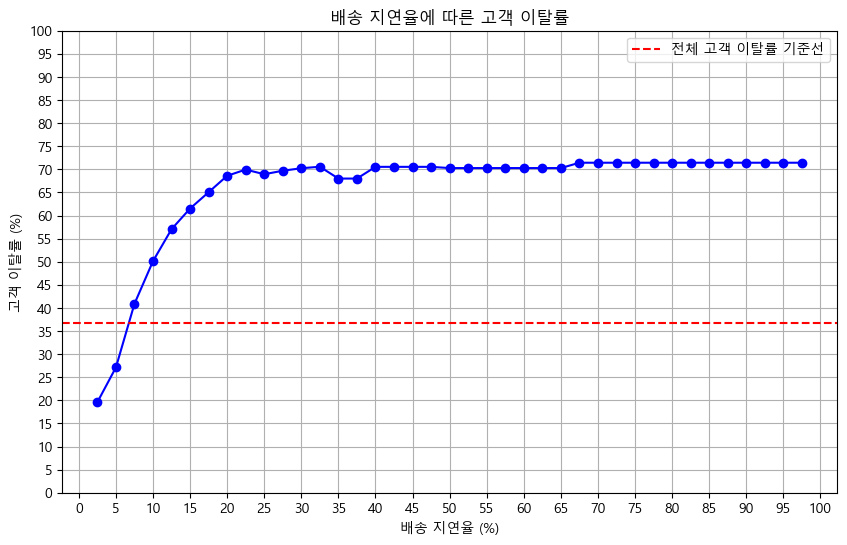

In [76]:
late_exp_member_fin = pd.merge(late_exp_member_fin, temp2)
late_exp_member_fin = pd.merge(late_exp_member_fin, temp)
late_exp_member_fin['배송지연비율'] = late_exp_member_fin['delivery_count'] / late_exp_member_fin['주문횟수']
ghost_cond = (active_member['최신주문일시'] < datetime.datetime(2021, 8, 30))


# 전체 고객 중 이탈 회원
ghost = active_member.loc[ghost_cond]

# 전체 고객 중 탈퇴 회원
passive = df_member.loc[df_member['회원상태'] != '정상회원']

# 전체 고객 이탈률
n_churn = len(ghost)+ len(passive)  # 전체 이탈고객 수
n_total = len(df_member)  # 전체 고객 수

p2 = n_churn / n_total  # 전체 고객 이탈률

alpha = 0.05 # 유의수준

p_list = []
churn_list = []

for i in range(1, 40):
    p = i / 40
    late_exp_member_fin_p = late_exp_member_fin.loc[late_exp_member_fin['배송지연비율'] > p]
    
    late_ghost_fin = late_exp_member_fin_p.loc[late_exp_member_fin_p['최신주문일시'] < datetime.datetime(2021, 8, 30)]
    late_passive_fin = late_exp_member_fin_p.loc[late_exp_member_fin_p['회원상태'] != '정상회원']

    churn_rate_fin = (len(late_ghost_fin) + len(late_passive_fin)) / len(late_exp_member_fin_p) * 100

    p_list.append(p * 100)  
    churn_list.append(np.round(churn_rate_fin, 3))  


    count = np.array([(len(late_ghost_fin) + len(late_passive_fin)), n_churn])
    nobs = np.array([len(late_exp_member_fin_p), n_total])
    z_score, p_value = sm.stats.proportions_ztest(count, nobs)
    
    # 결과 출력
    print(f"배송지연율:{p*100}%")
    print(f"고객이탈률:{np.round(churn_rate_fin, 3)}%")   
    print(f"Z-score: {z_score}")
    print(f"P-value: {p_value}")


    if p_value < alpha:
        print("귀무가설을 기각합니다. 배송 지연 비율은 고객 이탈과 상관이 있습니다.")
    else:
        print("귀무가설을 기각할 수 없습니다. 배송 지연 비율은 고객 이탈과 상관이 없습니다.")

    print("=============================")







# 꺾은 선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(p_list, churn_list, marker='o', linestyle='-', color='b')
plt.title('배송 지연율에 따른 고객 이탈률')
plt.xlabel('배송 지연율 (%)')
plt.ylabel('고객 이탈률 (%)')
plt.grid()
plt.xticks(np.arange(0, 101, 5))
plt.yticks(np.arange(0, 101, 5))
plt.axhline(y=36.68261562998405, color='r', linestyle='--', label='전체 고객 이탈률 기준선')
plt.legend()
plt.savefig("churn_vs_late.png")
plt.show()



### 전체 고객 중 고객 이탈률(유령회원 + 탈퇴)

In [49]:
# 전체 고객 중 유령회원
ghost_cond = (active_member['최신주문일시'] < datetime.datetime(2021, 8, 30))

ghost = active_member.loc[ghost_cond]

# 전체 고객 중 탈퇴 회원
passive = df_member.loc[df_member['회원상태'] != '정상회원']


(len(ghost)+ len(passive)) / len(df_member) * 100

36.68261562998405

### 배송 지연 경험률이 n% 초과인 고객 중 구독률

In [50]:
len(late_exp_member2.loc[late_exp_member2['구독여부'] == 'True']) / len(late_exp_member2)

0.1294021294021294

In [51]:
# 전체 고객의 구독률을 13.8~% 였음. 크게 차이가 나지는 않는 것으로 보이긴 하는데 가설검정 해보기

### 가설 검정

In [52]:
# 배송 지연 경험이 있는 고객의 이탈률
n_late_churn = len(late_ghost) + len(late_passive)  # 배송 지연 경험이 있는 이탈고객 수
n_late_total = len(late_exp_member2)  # 배송 지연 경험이 있는 전체 고객 수

# 전체 고객 이탈률
n_churn = len(ghost)+ len(passive)  # 전체 이탈고객 수
n_total = len(df_member)  # 전체 고객 수

# 비율 계산
p1 = n_late_churn / n_late_total  # 배송 지연 경험이 있는 고객의 이탈률
p2 = n_churn / n_total  # 전체 고객 이탈률

# Z-검정 수행
count = np.array([n_late_churn, n_churn])
nobs = np.array([n_late_total, n_total])

z_score, p_value = sm.stats.proportions_ztest(count, nobs)

# 결과 출력
print(f"Z-검정 통계량: {z_score}")
print(f"P-값: {p_value}")

# 유의수준 설정 (예: 0.05)
alpha = 0.05
if p_value < alpha:
    print("귀무가설을 기각합니다. 배송 지연 비율은 고객 이탈과 상관이 있습니다.")
else:
    print("귀무가설을 기각할 수 없습니다. 배송 지연 비율은 고객 이탈과 상관이 없습니다.")


Z-검정 통계량: 8.962353467756829
P-값: 3.17821174168606e-19
귀무가설을 기각합니다. 배송 지연 비율은 고객 이탈과 상관이 있습니다.


In [53]:
# 배송 지연 경험이 있는 고객의 구독률
n_late_sub = len(late_exp_member2.loc[late_exp_member2['구독여부'] == 'True'])  # 배송 지연 경험이 있는 구독 수

# 전체 고객  구독률
n_sub = len(df_member.loc[df_member['구독여부'] == 'True'])  # 전체 이탈고객 수

# 비율 계산
p1 = n_late_sub / n_late_total  # 배송 지연 경험이 있는 고객의 이탈률
p2 = n_sub / n_total  # 전체 고객 중 유령회원의 이탈률

# Z-검정 수행
count = np.array([n_late_sub, n_sub])
nobs = np.array([n_late_total, n_total])

z_score, p_value = sm.stats.proportions_ztest(count, nobs)

# 결과 출력
print(f"Z-검정 통계량: {z_score}")
print(f"P-값: {p_value}")

# 유의수준 설정 (예: 0.05)
alpha = 0.05
if p_value < alpha:
    print("귀무가설을 기각합니다. 배송 지연 비율은 구독률과 상관이 있습니다.")
else:
    print("귀무가설을 기각할 수 없습니다. 배송 지연 비율은 구독률과 상관이 없습니다.")


Z-검정 통계량: -1.0022589655809622
P-값: 0.31621853554386536
귀무가설을 기각할 수 없습니다. 배송 지연 비율은 구독률과 상관이 없습니다.


In [54]:
memberwise_delivery = df_sales.pivot_table(index=['회원번호', '주문일시', '배송완료일'], values='구매수량', aggfunc='count').reset_index()
memberwise_delivery[['주문일시', '배송완료일']] = memberwise_delivery[['주문일시', '배송완료일']].apply(pd.to_datetime)

temp3 = pd.merge(df_member, memberwise_delivery)
temp3['배송지연'] = 0
(temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)
temp3 = temp3.drop(columns=['배송완료일'])

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE  # 불균형 데이터 처리


# 특성 선택 및 타겟 변수 설정
X = temp3
y = temp3['배송지연']

X['성별'] = X['성별'].dropna()
X['성별'] = X['성별'].replace({'남': 1, '여': 0})
X['회원상태'] = X['회원상태'].replace({'정상회원': 1, '탈퇴': 0, '탈퇴신청': 0, '탈퇴처리중': 0, np.nan: 0}).astype(int)
X['결혼'] = X['결혼'].dropna()
X['결혼'] = X['결혼'].replace({'기혼':1, '미혼':0})

# 구독여부의 'nan' 문자열을 np.nan으로 변환
X['구독여부'] = X['구독여부'].replace('nan', np.nan)

# nan 값을 0으로 대체하고, True는 1로, False는 0으로 변환
X['구독여부'] = X['구독여부'].fillna(0).replace({'False': 0, 'True': 1}).astype(int)
X['월'] = X['주문일시'].dt.month

# drop 메서드에서 inplace=True를 제거
X = X.drop('주문일시', axis=1)
X = X.drop(columns=['회원번호', '배송지연', '세부주소지', '등록카드'])


X['주소지'] = X['주소지'].replace({
    '경기도': 0,
    '서울특별시': 1,
    '부산광역시': 2,
    '경상남도': 3,
    '경상북도': 4,
    '대구광역시': 5,
    '강원도': 6,
    '전라북도': 7,
    '충청남도': 8,
    '인천광역시': 9,
    '충청북도': 10,
    '대전광역시': 11,
    '울산광역시': 12,
    '전라남도': 13,
    '광주광역시': 14,
    '세종특별자치시': 15,
    '제주특별자치도': 16,
    '경기': 0,  # 경기도와 동일하게 매핑
    '광주': 14,  # 광주광역시와 동일하게 매핑
    '강원': 6,   # 강원도와 동일하게 매핑
    '서울': 1    # 서울특별시와 동일하게 매핑
})

# 5. ColumnTransformer 설정
# 예시: 범주형 변수와 수치형 변수를 구분하여 처리
categorical_features = ['회원상태', '성별', '결혼', '구독여부', '주소지', '클러스터', '월']  # 범주형 변수 목록
numerical_features = ['구매수량', '나이']  # 수치형 변수 목록

# ColumnTransformer 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# 6. 변환 실행
X_transformed = preprocessor.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# 모델 훈련
model = RandomForestClassifier(random_state=1234)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 모델 평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\eugin\AppData\Local\Temp\ipykernel_30296\94656526.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['주소지'] = X['주소지'].replace({


[[75364]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75364

    accuracy                           1.00     75364
   macro avg       1.00      1.00      1.00     75364
weighted avg       1.00      1.00      1.00     75364



C:\Users\eugin\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [57]:


# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 모든 하이퍼파라미터 조합 생성
param_list = list(ParameterGrid(param_grid))

# 최적의 모델과 최고 점수 초기화
best_model = None
best_score = 0

# tqdm을 사용하여 진행 상황 표시
with tqdm(total=len(param_list), desc='Grid Search Progress') as pbar:
    for params in param_list:
        # 모델 생성 및 학습
        model = RandomForestClassifier(random_state=1234, **params)
        model.fit(X_train, y_train)
        
        # 예측 및 평가
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred)  # f1_score를 계산
        
        # 최고 점수 업데이트
        if score > best_score:
            best_score = score
            best_model = model
        
        pbar.update(1)  # 진행 상황 업데이트

# 모델 평가
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Grid Search Progress:   0%|          | 0/108 [00:00<?, ?it/s]C:\Users\eugin\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Grid Search Progress:   1%|          | 1/108 [00:01<02:29,  1.40s/it]C:\Users\eugin\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Grid Search Progress:   2%|▏         | 2/108 [00:04<03:43,  2.11s/it]C:\Users\eugin\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-d

AttributeError: 'NoneType' object has no attribute 'predict'

In [58]:
temp3

,회원번호,회원상태,성별,나이,등록카드,결혼,구독여부,주소지,세부주소지,클러스터,주문일시,구매수량,배송지연,월
0,18764160,1,0.0,68,농협중앙회,1.0,0,서울특별시,성동구,0,2021-01-03,1,0,1
1,18764160,1,0.0,68,농협중앙회,1.0,0,서울특별시,성동구,0,2021-01-03,1,0,1
2,18764160,1,0.0,68,농협중앙회,1.0,0,서울특별시,성동구,0,2021-01-23,2,0,1
3,18764160,1,0.0,68,농협중앙회,1.0,0,서울특별시,성동구,0,2021-01-23,1,0,1
4,18764160,1,0.0,68,농협중앙회,1.0,0,서울특별시,성동구,0,2021-03-30,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376814,1670620864,1,1.0,100,우리은행,1.0,0,대구광역시,북구,0,2021-04-30,1,0,4
376815,1670620864,1,1.0,100,우리은행,1.0,0,대구광역시,북구,0,2021-04-30,1,0,4
376816,1670620864,1,1.0,100,우리은행,1.0,0,대구광역시,북구,0,2021-06-02,1,0,6
376817,1670620864,1,1.0,100,우리은행,1.0,0,대구광역시,북구,0,2021-06-02,1,0,6


In [59]:

memberwise_delivery = df_sales.pivot_table(index=['회원번호', '주문일시', '배송완료일'], values='구매수량', aggfunc='count').reset_index()
memberwise_delivery[['주문일시', '배송완료일']] = memberwise_delivery[['주문일시', '배송완료일']].apply(pd.to_datetime)

temp3 = pd.merge(df_member, memberwise_delivery)
# 1. 타겟 변수 (배송지연) 재설정
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)


In [60]:
temp3

,회원번호,회원상태,성별,나이,등록카드,결혼,구독여부,주소지,세부주소지,클러스터,주문일시,배송완료일,구매수량,배송지연
0,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구,0,2021-01-03,2021-01-03,1,0
1,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구,0,2021-01-03,2021-01-06,1,1
2,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구,0,2021-01-23,2021-01-25,2,0
3,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구,0,2021-01-23,2021-01-26,1,1
4,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구,0,2021-03-30,2021-03-30,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376814,1670620864,정상회원,남,100,우리은행,기혼,nan,대구광역시,북구,0,2021-04-30,2021-04-30,1,0
376815,1670620864,정상회원,남,100,우리은행,기혼,nan,대구광역시,북구,0,2021-04-30,2021-05-01,1,0
376816,1670620864,정상회원,남,100,우리은행,기혼,nan,대구광역시,북구,0,2021-06-02,2021-06-03,1,0
376817,1670620864,정상회원,남,100,우리은행,기혼,nan,대구광역시,북구,0,2021-06-02,2021-06-04,1,0


In [61]:
X = temp3

# 2. 범주형 변수 처리
X['성별'] = X['성별'].replace({'남': 1, '여': 0})
X['회원상태'] = X['회원상태'].replace({'정상회원': 1, '탈퇴': 0, '탈퇴신청': 0, '탈퇴처리중': 0, np.nan: 0}).astype(int)
X['결혼'] = X['결혼'].replace({'기혼': 1, '미혼': 0})
X['구독여부'] = X['구독여부'].replace('nan', np.nan).fillna(0).replace({'False': 0, 'True': 1}).astype(int)
X['월'] = X['주문일시'].dt.month

# 3. 필요 없는 컬럼 제거
X = temp3.drop(columns=['회원번호', '배송완료일', '주문일시', '세부주소지', '등록카드', '배송지연'])
y = temp3['배송지연']

X['주소지'] = X['주소지'].replace({
    '경기도': 0, '서울특별시': 1, '부산광역시': 2, '경상남도': 3, '경상북도': 4, '대구광역시': 5, '강원도': 6,
    '전라북도': 7, '충청남도': 8, '인천광역시': 9, '충청북도': 10, '대전광역시': 11, '울산광역시': 12, '전라남도': 13,
    '광주광역시': 14, '세종특별자치시': 15, '제주특별자치도': 16, '경기': 0, '광주': 14, '강원': 6, '서울': 1
})



# 4. 전처리 (표준화 + 원-핫 인코딩)
categorical_features = ['회원상태', '성별', '결혼', '구독여부', '주소지', '클러스터', '월']
numerical_features = ['구매수량', '나이']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_transformed = preprocessor.fit_transform(X)

# 5. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=1234, stratify=y)

# 6. 데이터 불균형 처리
smote = SMOTE(random_state=1234)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 7. 랜덤포레스트 모델 훈련 (하이퍼파라미터 조정)
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1234)
model.fit(X_train, y_train)

# 8. 예측 및 평가
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


C:\Users\eugin\AppData\Local\Temp\ipykernel_30296\2002232925.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['성별'] = X['성별'].replace({'남': 1, '여': 0})
C:\Users\eugin\AppData\Local\Temp\ipykernel_30296\2002232925.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['회원상태'] = X['회원상태'].replace({'정상회원': 1, '탈퇴': 0, '탈퇴신청': 0, '탈퇴처리중': 0, np.nan: 0}).astype(int)
C:\Users\eugin\AppData\Local\Temp\ipykernel_30296\2002232925.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future versio

[[30977 38584]
 [  589  5214]]
              precision    recall  f1-score   support

           0       0.98      0.45      0.61     69561
           1       0.12      0.90      0.21      5803

    accuracy                           0.48     75364
   macro avg       0.55      0.67      0.41     75364
weighted avg       0.91      0.48      0.58     75364



In [ ]:
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from joblib import Parallel, delayed
import joblib  # RandomForest 병렬 처리에 tqdm 적용


memberwise_delivery = df_sales.pivot_table(index=['회원번호', '주문일시', '배송완료일'], values='구매수량', aggfunc='count').reset_index()
memberwise_delivery[['주문일시', '배송완료일']] = memberwise_delivery[['주문일시', '배송완료일']].apply(pd.to_datetime)

temp3 = pd.merge(df_member, memberwise_delivery)
# 1. 타겟 변수 (배송지연) 재설정
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)



# 1. tqdm 설정
tqdm.pandas()

# 2. 타겟 변수 (배송지연) 재설정
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)


X = temp3

# 2. 범주형 변수 처리
X['성별'] = X['성별'].replace({'남': 1, '여': 0})
X['회원상태'] = X['회원상태'].replace({'정상회원': 1, '탈퇴': 0, '탈퇴신청': 0, '탈퇴처리중': 0, np.nan: 0}).astype(int)
X['결혼'] = X['결혼'].replace({'기혼': 1, '미혼': 0})
X['구독여부'] = X['구독여부'].replace('nan', np.nan).fillna(0).replace({'False': 0, 'True': 1}).astype(int)
X['월'] = X['주문일시'].dt.month

# 3. 필요 없는 컬럼 제거
X = temp3.drop(columns=['회원번호', '배송완료일', '주문일시', '세부주소지', '등록카드', '배송지연'])
y = temp3['배송지연']

X['주소지'] = X['주소지'].replace({
    '경기도': 0, '서울특별시': 1, '부산광역시': 2, '경상남도': 3, '경상북도': 4, '대구광역시': 5, '강원도': 6,
    '전라북도': 7, '충청남도': 8, '인천광역시': 9, '충청북도': 10, '대전광역시': 11, '울산광역시': 12, '전라남도': 13,
    '광주광역시': 14, '세종특별자치시': 15, '제주특별자치도': 16, '경기': 0, '광주': 14, '강원': 6, '서울': 1
})



# 5. 전처리 (표준화 + 원-핫 인코딩)
categorical_features = ['회원상태', '성별', '결혼', '구독여부', '주소지', '클러스터', '월']
numerical_features = ['구매수량', '나이']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


# tqdm 적용하여 변환 과정 시각화
X_transformed = preprocessor.fit_transform(X)  # np.array 변환 제거!


# 6. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=1234, stratify=y)

# 7. 데이터 불균형 처리
smote = SMOTE(random_state=1234)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 8. RandomForest에 tqdm 적용
def fit_with_progress(model, X_train, y_train):
    """ tqdm을 적용한 랜덤포레스트 학습 """
    with joblib.parallel_backend('threading', n_jobs=-1):  # 병렬 처리
        model.fit(X_train, y_train)

# 9. 랜덤포레스트 모델 훈련 (하이퍼파라미터 조정)
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1234, n_jobs=-1)

print("🔹 모델 학습 중...")
fit_with_progress(model, X_train, y_train)

# 10. 예측 및 평가
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


### 하이퍼파라미터 조정해서 다시 실행

In [ ]:
memberwise_delivery = df_sales.pivot_table(index=['회원번호', '주문일시', '배송완료일'], values='구매수량', aggfunc='count').reset_index()
memberwise_delivery[['주문일시', '배송완료일']] = memberwise_delivery[['주문일시', '배송완료일']].apply(pd.to_datetime)

temp3 = pd.merge(df_member, memberwise_delivery)
# 1. 타겟 변수 (배송지연) 재설정
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)



# 1. tqdm 설정
tqdm.pandas()

# 2. 타겟 변수 (배송지연) 재설정
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)


X = temp3

# 2. 범주형 변수 처리
X['성별'] = X['성별'].replace({'남': 1, '여': 0})
X['회원상태'] = X['회원상태'].replace({'정상회원': 1, '탈퇴': 0, '탈퇴신청': 0, '탈퇴처리중': 0, np.nan: 0}).astype(int)
X['결혼'] = X['결혼'].replace({'기혼': 1, '미혼': 0})
X['구독여부'] = X['구독여부'].replace('nan', np.nan).fillna(0).replace({'False': 0, 'True': 1}).astype(int)
X['월'] = X['주문일시'].dt.month

# 3. 필요 없는 컬럼 제거
X = temp3.drop(columns=['회원번호', '배송완료일', '주문일시', '세부주소지', '등록카드', '배송지연'])
y = temp3['배송지연']

X['주소지'] = X['주소지'].replace({
    '경기도': 0, '서울특별시': 1, '부산광역시': 2, '경상남도': 3, '경상북도': 4, '대구광역시': 5, '강원도': 6,
    '전라북도': 7, '충청남도': 8, '인천광역시': 9, '충청북도': 10, '대전광역시': 11, '울산광역시': 12, '전라남도': 13,
    '광주광역시': 14, '세종특별자치시': 15, '제주특별자치도': 16, '경기': 0, '광주': 14, '강원': 6, '서울': 1
})



# 5. 전처리 (표준화 + 원-핫 인코딩)
categorical_features = ['회원상태', '성별', '결혼', '구독여부', '주소지', '클러스터', '월']
numerical_features = ['구매수량', '나이']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


# tqdm 적용하여 변환 과정 시각화
X_transformed = preprocessor.fit_transform(X)  # np.array 변환 제거!


# 6. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=1234, stratify=y)

# 7. 데이터 불균형 처리
smote = SMOTE(random_state=1234, k_neighbors=3)  # 기본값 5 → 3으로 감소
X_train, y_train = smote.fit_resample(X_train, y_train)


# 8. RandomForest에 tqdm 적용
def fit_with_progress(model, X_train, y_train):
    """ tqdm을 적용한 랜덤포레스트 학습 """
    with joblib.parallel_backend('threading', n_jobs=-1):  # 병렬 처리
        model.fit(X_train, y_train)

# 9. 랜덤포레스트 모델 훈련 (하이퍼파라미터 조정)
model = RandomForestClassifier(
    n_estimators=200,  # 트리 개수 증가
    max_depth=15,  # 트리 깊이 증가
    random_state=1234,
    n_jobs=-1,
    class_weight='balanced'  # 클래스 불균형 조정
)


print("🔹 모델 학습 중...")
fit_with_progress(model, X_train, y_train)

# 10. 예측 및 평가
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
feature_names = preprocessor.get_feature_names_out()

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("RandomForest Feature Importance")
plt.show()

threshold = 0.01  # 중요도가 1% 이하인 변수 제거
selected_features = feature_names[feature_importances > threshold]
selected_features

In [ ]:
memberwise_delivery = df_sales.pivot_table(index=['회원번호', '주문일시', '배송완료일'], values='구매수량', aggfunc='count').reset_index()
memberwise_delivery[['주문일시', '배송완료일']] = memberwise_delivery[['주문일시', '배송완료일']].apply(pd.to_datetime)

temp3 = pd.merge(df_member, memberwise_delivery)
# 1. 타겟 변수 (배송지연) 재설정
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)



# 1. tqdm 설정
tqdm.pandas()

# 2. 타겟 변수 (배송지연) 재설정
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)


X = temp3

# 2. 범주형 변수 처리
X['성별'] = X['성별'].replace({'남': 1, '여': 0})
X['회원상태'] = X['회원상태'].replace({'정상회원': 1, '탈퇴': 0, '탈퇴신청': 0, '탈퇴처리중': 0, np.nan: 0}).astype(int)
X['결혼'] = X['결혼'].replace({'기혼': 1, '미혼': 0})
X['구독여부'] = X['구독여부'].replace('nan', np.nan).fillna(0).replace({'False': 0, 'True': 1}).astype(int)
X['월'] = X['주문일시'].dt.month



X['주소지'] = X['주소지'].replace({
    '경기도': 0, '서울특별시': 1, '부산광역시': 2, '경상남도': 3, '경상북도': 4, '대구광역시': 5, '강원도': 6,
    '전라북도': 7, '충청남도': 8, '인천광역시': 9, '충청북도': 10, '대전광역시': 11, '울산광역시': 12, '전라남도': 13,
    '광주광역시': 14, '세종특별자치시': 15, '제주특별자치도': 16, '경기': 0, '광주': 14, '강원': 6, '서울': 1
})

# 3. 필요 없는 컬럼 제거
X = X.drop(columns=['회원번호', '배송완료일', '주문일시', '세부주소지', '등록카드', '배송지연', '클러스터', '주소지'])
y = temp3['배송지연']


# 5. 전처리 (표준화 + 원-핫 인코딩)
categorical_features = ['회원상태', '성별', '결혼', '구독여부', '월']
numerical_features = ['구매수량', '나이']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


# tqdm 적용하여 변환 과정 시각화
X_transformed = preprocessor.fit_transform(X)  # np.array 변환 제거!


# 6. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=1234, stratify=y)

# 7. 데이터 불균형 처리
smote = SMOTE(sampling_strategy=0.3, random_state=1234)
X_train, y_train = smote.fit_resample(X_train, y_train)


# 8. RandomForest에 tqdm 적용
def fit_with_progress(model, X_train, y_train):
    """ tqdm을 적용한 랜덤포레스트 학습 """
    with joblib.parallel_backend('threading', n_jobs=-1):  # 병렬 처리
        model.fit(X_train, y_train)

# 9. 랜덤포레스트 모델 훈련 (하이퍼파라미터 조정)
model = RandomForestClassifier(
    n_estimators=200,  # 트리 개수 증가
    max_depth=10,  # 트리 깊이 증가
    random_state=1234,
    n_jobs=-1,
    class_weight='balanced_subsample'  # 클래스 불균형 조정
)


print("🔹 모델 학습 중...")
fit_with_progress(model, X_train, y_train)

# 10. 예측 및 평가
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
memberwise_delivery = df_sales.pivot_table(index=['회원번호', '주문일시', '배송완료일','주문시간'], values='구매수량', aggfunc='count').reset_index()
memberwise_delivery[['주문일시', '배송완료일']] = memberwise_delivery[['주문일시', '배송완료일']].apply(pd.to_datetime)
temp3 = pd.merge(df_member, memberwise_delivery)

# 1. tqdm 설정
tqdm.pandas()

# 2. 타겟 변수 (배송지연) 재설정
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)

X = temp3

# 2. 범주형 변수 처리
X['성별'] = X['성별'].replace({'남': 1, '여': 0})
X['회원상태'] = X['회원상태'].replace({'정상회원': 1, '탈퇴': 0, '탈퇴신청': 0, '탈퇴처리중': 0, np.nan: 0}).astype(int)
X['결혼'] = X['결혼'].replace({'기혼': 1, '미혼': 0})
X['구독여부'] = X['구독여부'].replace('nan', np.nan).fillna(0).replace({'False': 0, 'True': 1}).astype(int)
X['월'] = X['주문일시'].dt.month



X['주소지'] = X['주소지'].replace({
    '경기도': 0, '서울특별시': 1, '부산광역시': 2, '경상남도': 3, '경상북도': 4, '대구광역시': 5, '강원도': 6,
    '전라북도': 7, '충청남도': 8, '인천광역시': 9, '충청북도': 10, '대전광역시': 11, '울산광역시': 12, '전라남도': 13,
    '광주광역시': 14, '세종특별자치시': 15, '제주특별자치도': 16, '경기': 0, '광주': 14, '강원': 6, '서울': 1
})


# 주문시간을 24시간 형식으로 변환
def convert_to_minutes(order_time):
    time_parts = order_time.split()
    period = time_parts[0]  # 오전/오후
    hour, minute = map(int, time_parts[1].split(':'))

    # 12시간 형식에서 24시간 형식으로 변환
    if period == '오후' and hour != 12:
        hour += 12
    elif period == '오전' and hour == 12:
        hour = 0

    # 총 분으로 변환
    return hour * 60 + minute

# 변환 적용
X['주문시간_분'] = X['주문시간'].apply(convert_to_minutes)


# 3. 필요 없는 컬럼 제거
X = X.drop(columns=['회원번호', '배송완료일', '주문일시', '세부주소지', '등록카드', '배송지연', '클러스터', '월', '주문시간','나이','결혼','성별','구독여부'])
y = temp3['배송지연']

# 5. 전처리 (표준화 + 원-핫 인코딩)
categorical_features = ['회원상태', '주소지']
numerical_features = ['구매수량', '주문시간_분']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


# tqdm 적용하여 변환 과정 시각화
X_transformed = preprocessor.fit_transform(X) 


# 6. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=1234)

# 7. 데이터 불균형 처리 (SMOTE 적용)
smote = SMOTE(sampling_strategy=0.4, random_state=1234)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 8. LightGBM 모델 설정
model = lgb.LGBMClassifier(
    n_estimators=200,  # 트리 개수 증가
    max_depth=15,      # 트리 깊이 제한
    learning_rate=0.05,  # 학습률 조정
    subsample=0.8,       # 과적합 방지 (데이터 일부만 사용)
    colsample_bytree=0.8, # 과적합 방지 (특성 일부만 사용)
    class_weight='balanced',  # 클래스 불균형 처리
    random_state=1234,
    n_jobs=-1
)

print("🔹 LightGBM 모델 학습 중...")
model.fit(X_train, y_train)

# 10. 예측 및 평가
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# 데이터 전처리
memberwise_delivery = df_sales.pivot_table(index=['회원번호', '주문일시', '배송완료일', '주문시간'], values='구매수량', aggfunc='count').reset_index()
memberwise_delivery[['주문일시', '배송완료일']] = memberwise_delivery[['주문일시', '배송완료일']].apply(pd.to_datetime)
temp3 = pd.merge(df_member, memberwise_delivery)

# tqdm 설정
tqdm.pandas()

# 타겟 변수 (배송지연) 재설정
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)

X = temp3

# 범주형 변수 처리
X['성별'] = X['성별'].replace({'남': 1, '여': 0})
X['회원상태'] = X['회원상태'].replace({'정상회원': 1, '탈퇴': 0, '탈퇴신청': 0, '탈퇴처리중': 0, np.nan: 0}).astype(int)
X['결혼'] = X['결혼'].replace({'기혼': 1, '미혼': 0})
X['구독여부'] = X['구독여부'].replace('nan', np.nan).fillna(0).replace({'False': 0, 'True': 1}).astype(int)
X['월'] = X['주문일시'].dt.month

X['주소지'] = X['주소지'].replace({
    '경기도': 0, '서울특별시': 1, '부산광역시': 2, '경상남도': 3, '경상북도': 4, '대구광역시': 5, '강원도': 6,
    '전라북도': 7, '충청남도': 8, '인천광역시': 9, '충청북도': 10, '대전광역시': 11, '울산광역시': 12, '전라남도': 13,
    '광주광역시': 14, '세종특별자치시': 15, '제주특별자치도': 16, '경기': 0, '광주': 14, '강원': 6, '서울': 1
})

# 주문시간을 24시간 형식으로 변환
def convert_to_minutes(order_time):
    time_parts = order_time.split()
    period = time_parts[0]  # 오전/오후
    hour, minute = map(int, time_parts[1].split(':'))

    # 12시간 형식에서 24시간 형식으로 변환
    if period == '오후' and hour != 12:
        hour += 12
    elif period == '오전' and hour == 12:
        hour = 0

    # 총 분으로 변환
    if (hour * 60 + minute) > 60*23:
        return 1 #(hour * 60 + minute)
    else:
        return 0 #(hour * 60 + minute)

# 변환 적용
X['주문시간_분'] = X['주문시간'].apply(convert_to_minutes)

# 필요 없는 컬럼 제거
X = X.drop(columns=['회원번호', '배송완료일', '주문일시', '세부주소지', '등록카드', '배송지연', '클러스터', '월', '주문시간', '나이', '결혼', '성별', '구독여부','회원상태'])
y = temp3['배송지연']

# 전처리 (표준화 + 원-핫 인코딩)
categorical_features = ['주소지']
numerical_features = ['구매수량', '주문시간_분']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# tqdm 적용하여 변환 과정 시각화
X_transformed = preprocessor.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=1234)

# 데이터 불균형 처리 (SMOTE 적용)
smote = SMOTE(sampling_strategy=0.5, random_state=1234)
X_train, y_train = smote.fit_resample(X_train, y_train)

# LightGBM 모델 설정
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,  # 트리 개수
    max_depth=10,      # 트리 깊이 제한
    random_state=1234,
    class_weight='balanced',  # 클래스 불균형 처리
    n_jobs=-1
)

# Random Forest 모델 설정
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=1234,
    class_weight='balanced',
    n_jobs=-1
)

# Voting Classifier 설정
voting_model = VotingClassifier(
    estimators=[('lgb', lgb_model), ('rf', rf_model)],
    voting='soft'  # soft voting 사용
)

print("🔹 앙상블 모델 학습 중...")
voting_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = voting_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from tqdm import tqdm
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


# 데이터 전처리
memberwise_delivery = df_sales.pivot_table(index=['회원번호', '주문일시', '배송완료일', '주문시간'], values='구매수량', aggfunc='count').reset_index()
memberwise_delivery[['주문일시', '배송완료일']] = memberwise_delivery[['주문일시', '배송완료일']].apply(pd.to_datetime)
temp3 = pd.merge(df_member, memberwise_delivery)

tqdm.pandas()

# 타겟 변수 (배송지연) 생성
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)

X = temp3

#  범주형 변수 처리
X['성별'] = X['성별'].replace({'남': 1, '여': 0})
X['회원상태'] = X['회원상태'].replace({'정상회원': 1, '탈퇴': 0, '탈퇴신청': 0, '탈퇴처리중': 0, np.nan: 0}).astype(int)
X['구독여부'] = X['구독여부'].replace('nan', np.nan).fillna(0).replace({'False': 0, 'True': 1}).astype(int)
X['월'] = X['주문일시'].dt.month

X['주소지'] = X['주소지'].replace({
    '경기도': 0, '서울특별시': 1, '부산광역시': 2, '경상남도': 3, '경상북도': 4, '대구광역시': 5, '강원도': 6,
    '전라북도': 7, '충청남도': 8, '인천광역시': 9, '충청북도': 10, '대전광역시': 11, '울산광역시': 12, '전라남도': 13,
    '광주광역시': 14, '세종특별자치시': 15, '제주특별자치도': 16, '경기': 0, '광주': 14, '강원': 6, '서울': 1, np.nan:1
})

#  주문시간 변환 (24시간 기반 범주화)
def convert_order_time(order_time):
    time_parts = order_time.split()
    period = time_parts[0]  # 오전/오후
    hour, minute = map(int, time_parts[1].split(':'))

    if period == '오후' and hour != 12:
        hour += 12
    elif period == '오전' and hour == 12:
        hour = 0

    # 시간대 범주화 (06-12: 아침 / 12-18: 점심 / 18-24: 저녁 / 00-06: 심야)
    if 6 <= hour < 12:
        return 0
    elif 12 <= hour < 18:
        return 1
    elif 18 <= hour < 24:
        return 2
    else:
        return 3

X['주문시간대'] = X['주문시간'].apply(convert_order_time)

#  필요 없는 컬럼 제거
X = X.drop(columns=['회원번호', '배송완료일', '주문일시', '세부주소지', '등록카드', '배송지연', '클러스터', '월', '주문시간'])
y = temp3['배송지연']

#  전처리 (표준화 + 원-핫 인코딩)
categorical_features = ['주소지', '주문시간대']
numerical_features = ['구매수량']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_transformed = preprocessor.fit_transform(X)

#  데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=1234)
print('split done')

# 데이터 불균형 처리 (SMOTE 적용)
smote = SMOTE(sampling_strategy=0.5, random_state=1234)
X_train, y_train = smote.fit_resample(X_train, y_train)
print('model setting start')

#  개별 모델 설정
lgb_model = lgb.LGBMClassifier(n_estimators=250, max_depth=12, learning_rate=0.05, random_state=1234, n_jobs=-1)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=1234, n_jobs=-1)
gb_model = GradientBoostingClassifier(n_estimators=250, max_depth=12, learning_rate=0.05, random_state=1234)
lr_model = LogisticRegression(max_iter=200, class_weight='balanced', random_state=1234)

#  Voting Classifier (가중치 조정)
voting_model = VotingClassifier(
    estimators=[('lgb', lgb_model), ('rf', rf_model), ('gb', gb_model), ('lr', lr_model)],
    voting='soft',
    weights=[3, 2, 2, 1]  # LGBM > RF/GB > LR 가중치 부여
)

print("🔹 앙상블 모델 학습 중...")
voting_model.fit(X_train, y_train)

#  예측 및 평가
y_pred = voting_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
from imblearn.under_sampling import RandomUnderSampler  # 언더샘플링을 위한 라이브러리

# 데이터 전처리
memberwise_delivery = df_sales.pivot_table(index=['회원번호', '주문일시', '배송완료일', '주문시간'], values='구매수량', aggfunc='count').reset_index()
memberwise_delivery[['주문일시', '배송완료일']] = memberwise_delivery[['주문일시', '배송완료일']].apply(pd.to_datetime)
temp3 = pd.merge(df_member, memberwise_delivery)

# tqdm 설정
tqdm.pandas()

# 타겟 변수 (배송지연) 재설정
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)

X = temp3

# 범주형 변수 처리
X['성별'] = X['성별'].replace({'남': 1, '여': 0})
X['회원상태'] = X['회원상태'].replace({'정상회원': 1, '탈퇴': 0, '탈퇴신청': 0, '탈퇴처리중': 0, np.nan: 0}).astype(int)
X['결혼'] = X['결혼'].replace({'기혼': 1, '미혼': 0})
X['구독여부'] = X['구독여부'].replace('nan', np.nan).fillna(0).replace({'False': 0, 'True': 1}).astype(int)
X['월'] = X['주문일시'].dt.month

X['주소지'] = X['주소지'].replace({
    '경기도': 0, '서울특별시': 1, '부산광역시': 2, '경상남도': 3, '경상북도': 4, '대구광역시': 5, '강원도': 6,
    '전라북도': 7, '충청남도': 8, '인천광역시': 9, '충청북도': 10, '대전광역시': 11, '울산광역시': 12, '전라남도': 13,
    '광주광역시': 14, '세종특별자치시': 15, '제주특별자치도': 16, '경기': 0, '광주': 14, '강원': 6, '서울': 1, np.nan:1
})

# 주문시간을 24시간 형식으로 변환
def convert_to_minutes(order_time):
    time_parts = order_time.split()
    period = time_parts[0]  # 오전/오후
    hour, minute = map(int, time_parts[1].split(':'))

    # 12시간 형식에서 24시간 형식으로 변환
    if period == '오후' and hour != 12:
        hour += 12
    elif period == '오전' and hour == 12:
        hour = 0

    # 총 분으로 변환
    if (hour * 60 + minute) > 60*23.5:
        return 1 #hour * 60 + minute
    else:
        return 0 # hour * 60 + minute

# 변환 적용
X['주문시간_분'] = X['주문시간'].apply(convert_to_minutes)

# 필요 없는 컬럼 제거
X = X.drop(columns=['회원번호', '배송완료일', '주문일시', '세부주소지', '등록카드', '배송지연', '클러스터', '월', '주문시간', '나이', '결혼', '성별', '구독여부','회원상태'])
y = temp3['배송지연']

# 전처리 (표준화 + 원-핫 인코딩)
categorical_features = ['주소지']
numerical_features = ['구매수량','주문시간_분']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# tqdm 적용하여 변환 과정 시각화
X_transformed = preprocessor.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.25, random_state=1234, stratify=y)

# 데이터 불균형 처리 (SMOTE 적용)
under_sampler = RandomUnderSampler(random_state=1234)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)

# LightGBM 모델 설정
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,  # 트리 개수
    max_depth=15,      # 트리 깊이 제한
    random_state=1234,
#    class_weight='balanced',  # 클래스 불균형 처리
    n_jobs=-1
)

# Random Forest 모델 설정
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=1234,
    class_weight='balanced',
    n_jobs=-1
)

# Voting Classifier 설정
voting_model = VotingClassifier(
    estimators=[('lgb', lgb_model), ('rf', rf_model)],
    voting='soft'  # soft voting 사용
)

print("🔹 앙상블 모델 학습 중...")
voting_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = voting_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


### 복합 샘플링

In [ ]:
## from tqdm import tqdm
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.combine import SMOTEENN
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# 데이터 전처리
memberwise_delivery = df_sales.pivot_table(index=['회원번호', '주문일시', '배송완료일', '주문시간'], values='구매수량', aggfunc='count').reset_index()
memberwise_delivery[['주문일시', '배송완료일']] = memberwise_delivery[['주문일시', '배송완료일']].apply(pd.to_datetime)
temp3 = pd.merge(df_member, memberwise_delivery)

# tqdm 설정
tqdm.pandas()

# 타겟 변수 (배송지연) 재설정
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)

X = temp3

# 범주형 변수 처리
X['성별'] = X['성별'].replace({'남': 1, '여': 0})
X['회원상태'] = X['회원상태'].replace({'정상회원': 1, '탈퇴': 0, '탈퇴신청': 0, '탈퇴처리중': 0, np.nan: 0}).astype(int)
X['결혼'] = X['결혼'].replace({'기혼': 1, '미혼': 0})
X['구독여부'] = X['구독여부'].replace('nan', np.nan).fillna(0).replace({'False': 0, 'True': 1}).astype(int)
X['월'] = X['주문일시'].dt.month

X['주소지'] = X['주소지'].replace({
    '경기도': 0, '서울특별시': 1, '부산광역시': 2, '경상남도': 3, '경상북도': 4, '대구광역시': 5, '강원도': 6,
    '전라북도': 7, '충청남도': 8, '인천광역시': 9, '충청북도': 10, '대전광역시': 11, '울산광역시': 12, '전라남도': 13,
    '광주광역시': 14, '세종특별자치시': 15, '제주특별자치도': 16, '경기': 0, '광주': 14, '강원': 6, '서울': 1, np.nan:1
})
X['주소지'] = X['주소지'].dropna()


# 주문시간을 24시간 형식으로 변환
def convert_to_minutes(order_time):
    if pd.isna(order_time):
        return np.nan  # NaN일 경우 NaN 반환
    time_parts = order_time.split()
    period = time_parts[0]  # 오전/오후
    hour, minute = map(int, time_parts[1].split(':'))

    # 12시간 형식에서 24시간 형식으로 변환
    if period == '오후' and hour != 12:
        hour += 12
    elif period == '오전' and hour == 12:
        hour = 0

    # 총 분으로 변환
    return 1 if (hour * 60 + minute) > 60*23.5 else 0

# 변환 적용
X['주문시간_분'] = X['주문시간'].progress_apply(convert_to_minutes)

# 필요 없는 컬럼 제거
X = X.drop(columns=['회원번호', '배송완료일', '주문일시', '세부주소지', '등록카드', '배송지연', '클러스터', '월', '주문시간', '나이', '결혼', '성별', '구독여부','회원상태'])
y = temp3['배송지연']

# 전처리 (표준화 + 원-핫 인코딩)
categorical_features = ['주소지']
numerical_features = ['구매수량', '주문시간_분']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)


# 혼합 샘플링 적용 (SMOTE + ENN)
smote_enn = SMOTEENN(random_state=1234)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

# LightGBM 모델 설정
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=17,
    random_state=1234,
    n_jobs=-1
)

# Random Forest 모델 설정
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=17,
    random_state=1234,
    class_weight='balanced',
    n_jobs=-1
)

# Voting Classifier 설정
voting_model = VotingClassifier(
    estimators=[('lgb', lgb_model), ('rf', rf_model)],
    voting='soft'
)

print("🔹 앙상블 모델 학습 중...")
voting_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = voting_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
import lightgbm as lgb

memberwise_delivery = df_sales.pivot_table(index=['회원번호', '주문일시', '배송완료일'], values='구매수량', aggfunc='count').reset_index()
memberwise_delivery[['주문일시', '배송완료일']] = memberwise_delivery[['주문일시', '배송완료일']].apply(pd.to_datetime)

temp3 = pd.merge(df_member, memberwise_delivery)





# 1. tqdm 설정
tqdm.pandas()

# 2. 타겟 변수 (배송지연) 재설정
temp3['배송지연'] = ((temp3['배송완료일'] - temp3['주문일시']) > datetime.timedelta(days=2)).astype(int)


X = temp3

# 2. 범주형 변수 처리
X['성별'] = X['성별'].replace({'남': 1, '여': 0})
X['회원상태'] = X['회원상태'].replace({'정상회원': 1, '탈퇴': 0, '탈퇴신청': 0, '탈퇴처리중': 0, np.nan: 0}).astype(int)
X['결혼'] = X['결혼'].replace({'기혼': 1, '미혼': 0})
X['구독여부'] = X['구독여부'].replace('nan', np.nan).fillna(0).replace({'False': 0, 'True': 1}).astype(int)
X['월'] = X['주문일시'].dt.month



X['주소지'] = X['주소지'].replace({
    '경기도': 0, '서울특별시': 1, '부산광역시': 2, '경상남도': 3, '경상북도': 4, '대구광역시': 5, '강원도': 6,
    '전라북도': 7, '충청남도': 8, '인천광역시': 9, '충청북도': 10, '대전광역시': 11, '울산광역시': 12, '전라남도': 13,
    '광주광역시': 14, '세종특별자치시': 15, '제주특별자치도': 16, '경기': 0, '광주': 14, '강원': 6, '서울': 1, np.nan:1
})

# 3. 필요 없는 컬럼 제거
X = X.drop(columns=['회원번호', '배송완료일', '주문일시', '세부주소지', '등록카드', '배송지연', '클러스터', '월'])
y = temp3['배송지연']




# 5. 전처리 (표준화 + 원-핫 인코딩)
categorical_features = ['회원상태', '성별', '결혼', '구독여부', '주소지',]
numerical_features = ['구매수량', '나이']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


# tqdm 적용하여 변환 과정 시각화
X_transformed = preprocessor.fit_transform(X) 


# 6. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=1234)

# 7. 데이터 불균형 처리 (SMOTE 적용)
smote = SMOTE(sampling_strategy=0.4, random_state=1234)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 8. LightGBM 모델 설정
model = lgb.LGBMClassifier(
    n_estimators=300,  # 트리 개수 증가
    max_depth=20,      # 트리 깊이 제한
    learning_rate=0.07,  # 학습률 조정
    subsample=1,       # 과적합 방지 (데이터 일부만 사용)
    colsample_bytree=1, # 과적합 방지 (특성 일부만 사용)
    class_weight='balanced',  # 클래스 불균형 처리
    random_state=1234,
    n_jobs=-1
)

print("🔹 LightGBM 모델 학습 중...")
model.fit(X_train, y_train)

# 10. 예측 및 평가
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


# Feature 5.
- 구매내역, 구매주기, 배송지연빈도(혹은 유무), 구독 유무들을 input으로 받아 특정 고객의 이탈이나 유령고객이 될 확률을 계산하는 모델 생성.

-다. 다양한 input을 시도하거나, 확률이 아닌 분류모델로 만드것도 는 .다. 독립변수와 설명변수 사이 관계를 살펴보는 것도 필요할 수 있으니, 다양한 관점에서 유령고객이나 이탈 살펴보기다.

In [62]:
# 탈퇴 / 탈퇴 신청 회원번호 리스트
inactive_list = list(df_member.loc[df_member['회원상태'] != '정상회원']['회원번호'].values)

# 탈퇴회원이 아니면서, 배송지연경험이 10%초과인 그룹
late_exp_member2


# 탈퇴회원 주문내역
df_sales.loc[df_sales['회원번호'].isin(inactive_list)].sort_values(by=['회원번호', '주문일시','배송완료일'], ascending=[True, True, True])


,회원번호,회원상태,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,주문시간,제품번호
199000,38866496,탈퇴,1.0,4020,2021-08-14,2021-08-14,2021-08-15,0,0,NaN,오후 08:05,100021612V2_1203
199001,38866496,탈퇴,1.0,3829,2021-08-14,2021-08-14,2021-08-16,0,0,NaN,오후 08:05,1000216V2_12
198996,38866496,탈퇴,1.0,5552,2021-08-14,NaT,NaT,0,0,주문취소,오후 08:05,100021461V2_1119
549889,51927168,탈퇴,2.0,31396,2021-07-16,2021-07-17,2021-07-18,0,0,NaN,오전 08:50,100021663V2_1244
653447,53361856,탈퇴,1.0,14167,2021-01-05,2021-01-05,2021-01-05,0,0,NaN,오전 01:38,100021218V2_924
...,...,...,...,...,...,...,...,...,...,...,...,...
283742,1670400000,탈퇴,2.0,4212,2021-10-30,2021-10-30,2021-10-30,0,0,NaN,오후 05:20,100021075V2_808
283739,1670400000,탈퇴,1.0,10338,2021-10-30,2021-10-30,2021-10-31,0,0,NaN,오후 05:20,100021783V2_1337
294320,1670400000,탈퇴,1.0,11486,2021-10-31,2021-10-31,2021-10-31,0,0,NaN,오후 04:56,10002380V2_292
294321,1670400000,탈퇴,1.0,9189,2021-10-31,2021-10-31,2021-10-31,0,0,NaN,오후 04:56,100021461V2_1119


In [63]:
active_member = df_member[df_member['회원상태'] == '정상회원']['회원번호']
active_member = pd.merge(active_member, ppp_result.drop_duplicates(subset='회원번호'))
# 유령회원 판별을 위한 최신주문일시 칼럼 추가
temp = memberwise_sales.pivot_table(index='회원번호', values='주문일시', aggfunc='max').rename(columns={'주문일시':'최신주문일시'}).reset_index()
active_member = pd.merge(active_member, temp)

# 배송 지연 비율 구하기 위한 칼럼 추가
temp2 = df_sales.pivot_table(index='회원번호', values='주문일시', aggfunc='count').rename(columns={'주문일시': '주문횟수'}).reset_index()
active_member = pd.merge(active_member,temp2)

active_member = pd.merge(df_member, active_member)
memberwise_sales.pivot_table(index='회원번호', values='주문시간', aggfunc='sum')
active_member['isghost'] = active_member['최신주문일시'] < datetime.datetime(2021,8,30)

active_member = pd.merge(active_member, deli_result)
active_member['배송지연비율'] = active_member['delivery_count'] / active_member['주문횟수']
active_member

,회원번호,회원상태,성별,나이,등록카드,결혼,구독여부,주소지,세부주소지,클러스터,평균구매주기,최신주문일시,주문횟수,isghost,delivery_count,배송지연비율
0,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구,0,19 days 17:08:34.285714285,2021-10-06,36,False,4,0.111111
1,18792000,정상회원,남,83,연결앱결제,NaN,False,강원도,강릉시,0,NaT,2021-04-05,1,True,0,0.000000
2,18942336,정상회원,여,39,신한은행,기혼,False,인천광역시,중구,1,23 days 16:00:00,2021-10-20,81,False,6,0.074074
3,18949760,정상회원,여,73,기업은행,NaN,nan,강원도,홍천군,0,NaT,2021-09-30,2,False,0,0.000000
4,19391488,정상회원,여,52,연결앱결제,기혼,False,대전광역시,중구,0,NaT,2021-05-19,1,True,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12375,1644772352,정상회원,여,50,국민카드,기혼,False,강원도,삼척시,0,NaT,2021-10-30,1,False,0,0.000000
12376,1644957952,정상회원,여,34,신한은행,미혼,False,부산광역시,중구,3,NaT,2021-10-30,6,False,1,0.166667
12377,1645334720,정상회원,남,24,국민카드,미혼,False,전라남도,여수시,3,NaT,2021-10-31,2,False,0,0.000000
12378,1670606016,정상회원,남,19,하나은행,미혼,nan,경상남도,밀양시,3,38 days 14:24:00,2021-10-12,35,False,0,0.000000


## 유령화 예측 모델

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 데이터 로드
data =active_member

# 결측치 처리
data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)

# '구독여부' 처리
data['구독여부'] = data['구독여부'].replace({'False': 0, 'True': 1, 'nan':0})

# 최신주문일시 처리
data['최신주문일시'] = pd.to_datetime(data['최신주문일시'])
data['최신주문일시'] = data['최신주문일시'].dt.dayofyear

# 평균구매주기를 timedelta로 변환
data['평균구매주기'] = pd.to_timedelta(data['평균구매주기'], errors='coerce').dt.days.fillna(0).astype(int)

# 범주형 변수 인코딩
label_encoders = {}
for column in ['회원상태', '성별', '등록카드', '결혼', '구독여부', '주소지', '세부주소지']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 특성과 타겟 변수 분리
X = data.drop(columns=['isghost', '회원상태', '최신주문일시', '회원번호']) # 전부 회원상태는 정상회원이니까 drop
y = data['isghost'].astype(int)  # 이진 분류를 위해 정수형으로 변환

# 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 랜덤 포레스트 모델 생성 및 학습
model = RandomForestClassifier(random_state=1234)
model.fit(X_train_scaled, y_train)

# 예측
y_pred = model.predict(X_test_scaled)

# 평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
# 특성 중요도 추출
importances = model.feature_importances_

# 특성 이름
feature_names = X.columns

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

### Gradient Boosting으로 변경

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 데이터 로드
data = active_member

# 결측치 처리
data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)

# '구독여부' 처리
data['구독여부'] = data['구독여부'].replace({'False': 0, 'True': 1, 'nan': 0})

# 최신주문일시 처리
data['최신주문일시'] = pd.to_datetime(data['최신주문일시'])
data['최신주문일시'] = data['최신주문일시'].dt.dayofyear

# 평균구매주기를 timedelta로 변환
data['평균구매주기'] = pd.to_timedelta(data['평균구매주기'], errors='coerce').dt.days.fillna(0).astype(int)

# 범주형 변수 인코딩
label_encoders = {}
for column in ['회원상태', '성별', '등록카드', '결혼', '구독여부', '주소지', '세부주소지']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 특성과 타겟 변수 분리
X = data.drop(columns=['isghost', '회원상태', '최신주문일시'])  # 전부 회원상태는 정상회원이니까 drop
y = data['isghost'].astype(int)  # 이진 분류를 위해 정수형으로 변환

# 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 그래디언트 부스팅 모델 생성 및 학습
model = GradientBoostingClassifier(random_state=1234)
model.fit(X_train_scaled, y_train)

# 예측
y_pred = model.predict(X_test_scaled)

# 평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


### GB, RF, LR voting classifier

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 데이터 로드
data = active_member

# 결측치 처리
data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)

# '구독여부' 처리
data['구독여부'] = data['구독여부'].replace({'False': 0, 'True': 1, 'nan': 0})

# 최신주문일시 처리
data['최신주문일시'] = pd.to_datetime(data['최신주문일시'])
data['최신주문일시'] = data['최신주문일시'].dt.dayofyear

# 평균구매주기를 timedelta로 변환
data['평균구매주기'] = pd.to_timedelta(data['평균구매주기'], errors='coerce').dt.days.fillna(0).astype(int)

# 범주형 변수 인코딩
label_encoders = {}
for column in ['회원상태', '성별', '등록카드', '결혼', '구독여부', '주소지', '세부주소지']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 특성과 타겟 변수 분리
X = data.drop(columns=['isghost', '회원상태', '최신주문일시'])  # 전부 회원상태는 정상회원이니까 drop
y = data['isghost'].astype(int)  # 이진 분류를 위해 정수형으로 변환

# 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 개별 모델 생성
rf_model = RandomForestClassifier(random_state=1234)
gb_model = GradientBoostingClassifier(random_state=1234)
lr_model = LogisticRegression(random_state=1234)

# VotingClassifier 생성
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('gb', gb_model),
    ('lr', lr_model)
], voting='soft')  # 'hard' voting을 사용

# 앙상블 모델 학습
voting_model.fit(X_train_scaled, y_train)

# 예측
y_pred = voting_model.predict(X_test_scaled)

# 평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


### SMOTE 오버 샘플링

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# 데이터 로드
data = active_member

# 결측치 처리
data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)

# '구독여부' 처리
data['구독여부'] = data['구독여부'].replace({'False': 0, 'True': 1, 'nan': 0})

# 최신주문일시 처리
data['최신주문일시'] = pd.to_datetime(data['최신주문일시'])
data['최신주문일시'] = data['최신주문일시'].dt.dayofyear

# 평균구매주기를 timedelta로 변환
data['평균구매주기'] = pd.to_timedelta(data['평균구매주기'], errors='coerce').dt.days.fillna(0).astype(int)

# 범주형 변수 인코딩
label_encoders = {}
for column in ['회원상태', '성별', '등록카드', '결혼', '구독여부', '주소지', '세부주소지']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 특성과 타겟 변수 분리
X = data.drop(columns=['isghost', '회원상태', '최신주문일시','회원번호','세부주소지'])  # 전부 회원상태는 정상회원이니까 drop
y = data['isghost'].astype(int)  # 이진 분류를 위해 정수형으로 변환

# 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# SMOTE를 사용하여 오버샘플링
smote = SMOTE(random_state=1234)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# 개별 모델 생성
rf_model = RandomForestClassifier(random_state=1234)
gb_model = GradientBoostingClassifier(random_state=1234)
lr_model = LogisticRegression(random_state=1234)

# VotingClassifier 생성
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('gb', gb_model),
    ('lr', lr_model)
], voting='soft')  # 'hard' voting을 사용

# 앙상블 모델 학습
voting_model.fit(X_train_scaled, y_train_resampled)

# 예측
y_pred = voting_model.predict(X_test_scaled)

# 평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
# 특성 중요도 추출
importances = voting_model.named_estimators_['rf'].feature_importances_  # RandomForestClassifier의 중요도 사용

# 특성 이름
feature_names = X.columns

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from tqdm import tqdm  

# 데이터 로드
data = active_member

# 결측치 처리
data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)
data['구독여부'] = data['구독여부'].replace({'False': 0, 'True': 1, 'nan': 0})

# 날짜 변환 및 Feature Engineering
data['평균구매주기'] = pd.to_timedelta(data['평균구매주기'], errors='coerce').dt.days.fillna(0).astype(int)
data['평균구매주기'] = np.log1p(data['평균구매주기'])  # 로그 변환

# 범주형 변수 인코딩
label_encoders = {}
for column in tqdm(['회원상태', '성별', '등록카드', '결혼', '구독여부', '주소지', '세부주소지'], desc="Encoding categorical variables"):
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 특성과 타겟 변수 분리
X = data.drop(columns=['isghost', '회원상태', '최신주문일시', '세부주소지'])
y = data['isghost'].astype(int)

# 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

# SMOTETomek을 사용하여 오버샘플링 및 노이즈 제거
smote_tomek = SMOTETomek(random_state=1234)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Random Forest 하이퍼파라미터 튜닝
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = RandomizedSearchCV(RandomForestClassifier(random_state=1234), rf_params, cv=3, n_iter=10, n_jobs=-1)

# Random Forest 모델 학습
tqdm.write("Training Random Forest...")
rf_grid.fit(X_train_scaled, y_train_resampled)
rf_best = rf_grid.best_estimator_

# Gradient Boosting 하이퍼파라미터 튜닝
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}
gb_grid = RandomizedSearchCV(GradientBoostingClassifier(random_state=1234), gb_params, cv=3, n_iter=10, n_jobs=-1)

# Gradient Boosting 모델 학습
tqdm.write("Training Gradient Boosting...")
gb_grid.fit(X_train_scaled, y_train_resampled)
gb_best = gb_grid.best_estimator_

# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(random_state=1234)

# Stacking 앙상블 모델 생성
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_best),
        ('gb', gb_best),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression()
)

# 모델 학습
tqdm.write("Training Stacking Model...")
stacking_model.fit(X_train_scaled, y_train_resampled)

# 예측
y_pred = stacking_model.predict(X_test_scaled)

# 평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from tqdm import tqdm  

# 데이터 로드
data = active_member

# 결측치 처리
data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)
data['구독여부'] = data['구독여부'].replace({'False': 0, 'True': 1, 'nan': 0})

# 날짜 변환 및 Feature Engineering
data['평균구매주기'] = pd.to_timedelta(data['평균구매주기'], errors='coerce').dt.days.fillna(0).astype(int)
data['평균구매주기'] = np.log1p(data['평균구매주기'])  # 로그 변환

# 범주형 변수 인코딩
label_encoders = {}
for column in tqdm(['회원상태', '성별', '등록카드', '결혼', '구독여부', '주소지', '세부주소지'], desc="Encoding categorical variables"):
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 특성과 타겟 변수 분리
X = data.drop(columns=['isghost', '회원상태', '최신주문일시', '세부주소지', '주소지', '평균구매주기', '회원번호'])
y = data['isghost'].astype(int)

# 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# SMOTETomek을 사용하여 오버샘플링 및 노이즈 제거
smote_tomek = SMOTETomek(random_state=1234)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Random Forest 하이퍼파라미터 튜닝
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = RandomizedSearchCV(RandomForestClassifier(random_state=1234), rf_params, cv=3, n_iter=10, n_jobs=-1)

# Random Forest 모델 학습
tqdm.write("Training Random Forest...")
rf_grid.fit(X_train_scaled, y_train_resampled)
rf_best = rf_grid.best_estimator_

# Gradient Boosting 하이퍼파라미터 튜닝
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}
gb_grid = RandomizedSearchCV(GradientBoostingClassifier(random_state=1234), gb_params, cv=3, n_iter=10, n_jobs=-1)

# Gradient Boosting 모델 학습
tqdm.write("Training Gradient Boosting...")
gb_grid.fit(X_train_scaled, y_train_resampled)
gb_best = gb_grid.best_estimator_

# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(random_state=1234)

# Stacking 앙상블 모델 생성
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_best),
        ('gb', gb_best),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression()
)

# 모델 학습
tqdm.write("Training Stacking Model...")
stacking_model.fit(X_train_scaled, y_train_resampled)

# 예측
y_pred = stacking_model.predict(X_test_scaled)

# 평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
# 특성 중요도 추출
importances = stacking_model.named_estimators_['rf'].feature_importances_  # RandomForestClassifier의 중요도 사용

# 특성 이름
feature_names = X.columns

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


### 분류모델에서 확률 모델로

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from tqdm import tqdm

# 데이터 로드
data = active_member

# 결측치 처리
data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)
data['구독여부'] = data['구독여부'].replace({'False': 0, 'True': 1, 'nan': 0})

# 날짜 변환 및 Feature Engineering
data['평균구매주기'] = pd.to_timedelta(data['평균구매주기'], errors='coerce').dt.days.fillna(0).astype(int)
data['평균구매주기'] = np.log1p(data['평균구매주기'])  # 로그 변환

# 범주형 변수 인코딩
label_encoders = {}
for column in tqdm(['회원상태', '성별', '등록카드', '결혼', '구독여부', '주소지', '세부주소지'], desc="Encoding categorical variables"):
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 특성과 타겟 변수 분리
X = data.drop(columns=['isghost', '회원상태', '최신주문일시', '세부주소지', '회원번호'])
y = data['isghost'].astype(int)

# 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# SMOTETomek을 사용하여 오버샘플링 및 노이즈 제거
smote_tomek = SMOTETomek(random_state=1234)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Random Forest 하이퍼파라미터 튜닝
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = RandomizedSearchCV(RandomForestClassifier(random_state=1234), rf_params, cv=3, n_iter=10, n_jobs=-1)

# Random Forest 모델 학습
tqdm.write("Training Random Forest...")
rf_grid.fit(X_train_scaled, y_train_resampled)
rf_best = rf_grid.best_estimator_

# Gradient Boosting 하이퍼파라미터 튜닝
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_grid = RandomizedSearchCV(GradientBoostingClassifier(random_state=1234), gb_params, cv=3, n_iter=10, n_jobs=-1)

# Gradient Boosting 모델 학습
tqdm.write("Training Gradient Boosting...")
gb_grid.fit(X_train_scaled, y_train_resampled)
gb_best = gb_grid.best_estimator_

# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(random_state=1234)

# Stacking 앙상블 모델 생성
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_best),
        ('gb', gb_best),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression()
)

# 모델 학습
tqdm.write("Training Stacking Model...")
stacking_model.fit(X_train_scaled, y_train_resampled)

# 유령 고객이 될 확률 예측
y_pred_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]  # Positive class의 확률

# 결과 출력
result_df = pd.DataFrame({'고객ID': X_test.index, '유령고객확률': y_pred_proba})
print(result_df)

C:\Users\eugin\AppData\Local\Temp\ipykernel_30296\2404627971.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)
C:\Users\eugin\AppData\Local\Temp\ipykernel_30296\2404627971.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['구독여부'] = data['구독여부'].replace({'False': 0, 'True': 1, 'nan': 0})
Encoding categorical variables: 100%|██████████| 7/7 [00:00<00:00, 832.20it/s]


Training Random Forest...
Training Gradient Boosting...
Training Stacking Model...
       고객ID    유령고객확률
0      9984  0.046199
1      6560  0.046427
2      6689  0.054457
3     10857  0.482805
4     11289  0.729031
...     ...       ...
2471   3646  0.043615
2472   7524  0.127545
2473  11813  0.262451
2474   6264  0.897675
2475   4139  0.901691

[2476 rows x 2 columns]


In [65]:
# 평가 (이진 분류 결과를 원할 경우)
y_pred = (y_pred_proba >= 0.22).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1079  447]
 [ 140  810]]
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1526
           1       0.64      0.85      0.73       950

    accuracy                           0.76      2476
   macro avg       0.76      0.78      0.76      2476
weighted avg       0.79      0.76      0.77      2476



           Feature  Importance
8             주문횟수    0.291724
7           평균구매주기    0.111672
1               나이    0.056046
9   delivery_count    0.052239
10          배송지연비율    0.047587
2             등록카드    0.038140
5              주소지    0.037556
6             클러스터    0.014394
3               결혼    0.007331
4             구독여부    0.006024
0               성별    0.003953


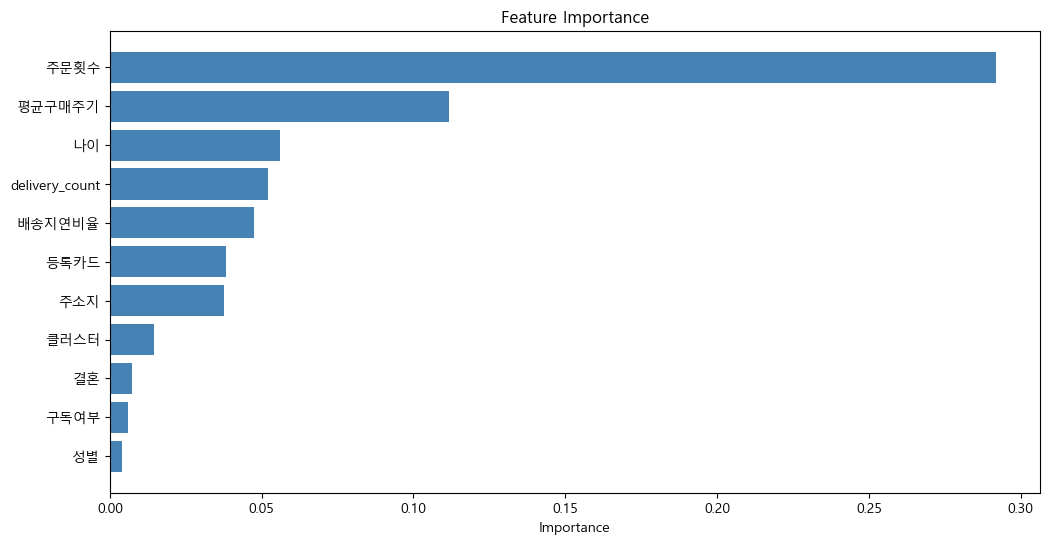

In [75]:
# 특성 중요도 추출
importances = np.zeros(X.shape[1])

# RandomForestClassifier의 특성 중요도 추가
if hasattr(rf_best, 'feature_importances_'):
    importances += rf_best.feature_importances_

# GradientBoostingClassifier의 특성 중요도 추가
if hasattr(gb_best, 'feature_importances_'):
    importances += gb_best.feature_importances_

# LogisticRegression의 경우 coef_를 사용하여 중요도 추가
if hasattr(lr_model, 'coef_'):
    importances += np.abs(lr_model.coef_[0])  # 절대값을 사용하여 중요도 반영

# 평균화
importances /= 3  # 기본 모델의 수로 나누기

# 특성 이름
feature_names = X.columns

# 결과를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 특성 중요도 출력
print(importance_df)

# 바 차트 시각화
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

## 탈퇴 예측 모델

In [ ]:
df_member.loc[df_member['회원번호'].isin(inactive_list)]

In [ ]:
inactive_sales = df_sales.loc[df_sales['회원번호'].isin(inactive_list)]
inactive_sales = inactive_sales.drop(inactive_sales[inactive_sales['주문취소여부'] == '주문취소'].index)

inactive_ppp_result = ppp(inactive_list, memberwise_sales).drop_duplicates(subset='회원번호')

inactive_member = pd.merge(df_member, inactive_ppp_result)

# 유령회원 판별을 위한 최신주문일시 칼럼 추가
temp = memberwise_sales.pivot_table(index='회원번호', values='주문일시', aggfunc='max').rename(columns={'주문일시':'최신주문일시'}).reset_index()
inactive_member = pd.merge(inactive_member, temp)

# 배송 지연 비율 구하기 위한 칼럼 추가
temp2 = inactive_sales.pivot_table(index='회원번호', values='주문일시', aggfunc='count').rename(columns={'주문일시': '주문횟수'}).reset_index()
inactive_member = pd.merge(inactive_member,temp2)

inactive_member = pd.merge(inactive_member, deli_result)
inactive_member['배송지연비율'] = inactive_member['delivery_count'] / inactive_member['주문횟수']
inactive_member['회원상태'] = '탈퇴'

In [ ]:
active_member = df_member[df_member['회원상태'] == '정상회원']['회원번호']
active_member = pd.merge(active_member, ppp_result.drop_duplicates(subset='회원번호'))
# 유령회원 판별을 위한 최신주문일시 칼럼 추가
temp = memberwise_sales.pivot_table(index='회원번호', values='주문일시', aggfunc='max').rename(columns={'주문일시':'최신주문일시'}).reset_index()
active_member = pd.merge(active_member, temp)

# 배송 지연 비율 구하기 위한 칼럼 추가
temp2 = df_sales.pivot_table(index='회원번호', values='주문일시', aggfunc='count').rename(columns={'주문일시': '주문횟수'}).reset_index()
active_member = pd.merge(active_member,temp2)

active_member = pd.merge(df_member, active_member)
memberwise_sales.pivot_table(index='회원번호', values='주문시간', aggfunc='sum')

active_member = pd.merge(active_member, deli_result)
active_member['배송지연비율'] = active_member['delivery_count'] / active_member['주문횟수']
active_member

In [ ]:
total_member = pd.concat([active_member, inactive_member])

In [ ]:
(set(df_member['회원번호']) - set((total_member['회원번호'])))
df_sales.loc[df_sales['회원번호'] == 529006400]
# 주문취소만 있는 탈퇴고객이 있어서 전체 구매 건수 -1

In [ ]:
total_member

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from tqdm import tqdm

# 데이터 로드
data = total_member

# 결측치 처리
data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)
data['구독여부'] = data['구독여부'].replace({'False': 0, 'True': 1, 'nan': 0})
data['회원상태'] = data['회원상태'].replace({'정상회원': 0, '탈퇴': 1}).fillna(0).astype(int)

# 날짜 변환 및 Feature Engineering
data['평균구매주기'] = pd.to_timedelta(data['평균구매주기'], errors='coerce').dt.days.fillna(0).astype(int)
data['평균구매주기'] = np.log1p(data['평균구매주기'])  # 로그 변환

# 최신주문일시 처리
data['최신주문일시'] = pd.to_datetime(data['최신주문일시'])
data['최신주문일시'] = data['최신주문일시'].dt.dayofyear

# 범주형 변수 인코딩
label_encoders = {}
for column in tqdm(['회원상태', '성별', '등록카드', '결혼', '구독여부', '주소지', '세부주소지'], desc="Encoding categorical variables"):
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 특성과 타겟 변수 분리
X = data.drop(columns=['회원상태','세부주소지', '회원번호'])
y = data['회원상태'].astype(int)

# 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# SMOTETomek을 사용하여 오버샘플링 및 노이즈 제거
smote_tomek = SMOTETomek(random_state=1234)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Random Forest 하이퍼파라미터 튜닝
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = RandomizedSearchCV(RandomForestClassifier(random_state=1234), rf_params, cv=3, n_iter=10, n_jobs=-1)

# Random Forest 모델 학습
tqdm.write("Training Random Forest...")
rf_grid.fit(X_train_scaled, y_train_resampled)
rf_best = rf_grid.best_estimator_

# Gradient Boosting 하이퍼파라미터 튜닝
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_grid = RandomizedSearchCV(GradientBoostingClassifier(random_state=1234), gb_params, cv=3, n_iter=10, n_jobs=-1)

# Gradient Boosting 모델 학습
tqdm.write("Training Gradient Boosting...")
gb_grid.fit(X_train_scaled, y_train_resampled)
gb_best = gb_grid.best_estimator_

# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(random_state=1234)

# Stacking 앙상블 모델 생성
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_best),
        ('gb', gb_best),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression()
)

# 모델 학습
tqdm.write("Training Stacking Model...")
stacking_model.fit(X_train_scaled, y_train_resampled)

# 유령 고객이 될 확률 예측
y_pred_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]  # Positive class의 확률

# 결과 출력
result_df = pd.DataFrame({'고객ID': X_test.index, '탈퇴확률': y_pred_proba})
print(result_df)

In [ ]:
# 평가 (이진 분류 결과를 원할 경우)
y_pred = (y_pred_proba >= 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from tqdm import tqdm

# 데이터 로드
data = total_member

# 결측치 처리
data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)
data['구독여부'] = data['구독여부'].replace({'False': 0, 'True': 1, 'nan': 0})
data['회원상태'] = data['회원상태'].replace({'정상회원': 0, '탈퇴': 1}).fillna(0).astype(int)

# 날짜 변환 및 Feature Engineering
data['평균구매주기'] = pd.to_timedelta(data['평균구매주기'], errors='coerce').dt.days.fillna(0).astype(int)
data['평균구매주기'] = np.log1p(data['평균구매주기'])  # 로그 변환

# 최신주문일시 처리
data['최신주문일시'] = pd.to_datetime(data['최신주문일시'])
data['최신주문일시'] = data['최신주문일시'].dt.dayofyear

# 범주형 변수 인코딩
label_encoders = {}
for column in tqdm(['회원상태', '성별', '등록카드', '결혼', '구독여부', '주소지', '세부주소지', '최신주문일시'], desc="Encoding categorical variables"):
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 특성과 타겟 변수 분리
X = data.drop(columns=['회원상태','세부주소지', '회원번호'])
y = data['회원상태'].astype(int)

# 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# SMOTETomek & ADASYN을 함께 적용하여 클래스 불균형 개선
smote_tomek = SMOTE(sampling_strategy='auto', random_state=1234)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)
adasyn = ADASYN(random_state=1234)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_resampled, y_train_resampled)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Random Forest 하이퍼파라미터 튜닝
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = RandomizedSearchCV(RandomForestClassifier(random_state=1234), rf_params, cv=3, n_iter=10, n_jobs=-1)

# Random Forest 모델 학습
tqdm.write("Training Random Forest...")
rf_grid.fit(X_train_scaled, y_train_resampled)
rf_best = rf_grid.best_estimator_

# Gradient Boosting 하이퍼파라미터 튜닝
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_grid = RandomizedSearchCV(GradientBoostingClassifier(random_state=1234), gb_params, cv=3, n_iter=10, n_jobs=-1)

# Gradient Boosting 모델 학습
tqdm.write("Training Gradient Boosting...")
gb_grid.fit(X_train_scaled, y_train_resampled)
gb_best = gb_grid.best_estimator_

# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(random_state=1234)

# Stacking 앙상블 모델 생성
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_best),
        ('gb', gb_best),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression()
)

# 모델 학습
tqdm.write("Training Stacking Model...")
stacking_model.fit(X_train_scaled, y_train_resampled)

# 유령 고객이 될 확률 예측
y_pred_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]  # Positive class의 확률

# Threshold 조정으로 Recall 향상
y_pred = (y_pred_proba >= 0.20).astype(int)

# 결과 출력
result_df = pd.DataFrame({'고객ID': X_test.index, '탈퇴확률': y_pred_proba})
print(result_df)

# 평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


### Voting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from tqdm import tqdm

# 데이터 로드
data = total_member

# 결측치 처리
data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)
data['구독여부'] = data['구독여부'].replace({'False': 0, 'True': 1, 'nan': 0})
data['회원상태'] = data['회원상태'].replace({'정상회원': 0, '탈퇴': 1}).fillna(0).astype(int)

# 날짜 변환 및 Feature Engineering
data['평균구매주기'] = pd.to_timedelta(data['평균구매주기'], errors='coerce').dt.days.fillna(0).astype(int)
data['평균구매주기'] = np.log1p(data['평균구매주기'])  # 로그 변환

# 최신주문일시 처리
data['최신주문일시'] = pd.to_datetime(data['최신주문일시'])
data['최신주문일시'] = data['최신주문일시'].dt.dayofyear

# 범주형 변수 인코딩
label_encoders = {}
for column in tqdm(['회원상태', '성별', '등록카드', '결혼', '구독여부', '주소지', '세부주소지', '최신주문일시'], desc="Encoding categorical variables"):
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 특성과 타겟 변수 분리
X = data.drop(columns=['회원상태','세부주소지', '회원번호'])
y = data['회원상태'].astype(int)

# 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# SMOTETomek & ADASYN을 함께 적용하여 클래스 불균형 개선
smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=1234)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)
adasyn = ADASYN(random_state=1234)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_resampled, y_train_resampled)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Random Forest 하이퍼파라미터 튜닝
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = RandomizedSearchCV(RandomForestClassifier(random_state=1234), rf_params, cv=3, n_iter=10, n_jobs=-1)

# Random Forest 모델 학습
tqdm.write("Training Random Forest...")
rf_grid.fit(X_train_scaled, y_train_resampled)
rf_best = rf_grid.best_estimator_

# Gradient Boosting 하이퍼파라미터 튜닝
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_grid = RandomizedSearchCV(GradientBoostingClassifier(random_state=1234), gb_params, cv=3, n_iter=10, n_jobs=-1)

# Gradient Boosting 모델 학습
tqdm.write("Training Gradient Boosting...")
gb_grid.fit(X_train_scaled, y_train_resampled)
gb_best = gb_grid.best_estimator_

# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(random_state=1234)

# Voting 앙상블 모델 생성
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_best),
        ('gb', gb_best),
        ('lr', lr_model)
    ],
    voting='soft'  # 'soft' voting을 사용하여 확률 기반 예측
)

# 모델 학습
tqdm.write("Training Voting Model...")
voting_model.fit(X_train_scaled, y_train_resampled)

# 유령 고객이 될 확률 예측
y_pred_proba = voting_model.predict_proba(X_test_scaled)[:, 1]  # Positive class의 확률

# Threshold 조정으로 Recall 향상
y_pred = (y_pred_proba >= 0.20).astype(int)

# 결과 출력
result_df = pd.DataFrame({'고객ID': X_test.index, '탈퇴확률': y_pred_proba})
print(result_df)

# 평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


### 언더샘플링

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm

# 데이터 로드
data = total_member

# 결측치 처리
data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)
data['구독여부'] = data['구독여부'].replace({'False': 0, 'True': 1, 'nan': 0})
data['회원상태'] = data['회원상태'].replace({'정상회원': 0, '탈퇴': 1}).fillna(0).astype(int)

# 날짜 변환 및 Feature Engineering
data['평균구매주기'] = pd.to_timedelta(data['평균구매주기'], errors='coerce').dt.days.fillna(0).astype(int)
data['평균구매주기'] = np.log1p(data['평균구매주기'])  # 로그 변환

# 최신주문일시 처리
data['최신주문일시'] = pd.to_datetime(data['최신주문일시'])
data['최신주문일시'] = data['최신주문일시'].dt.dayofyear

# 범주형 변수 인코딩
label_encoders = {}
for column in tqdm(['회원상태', '성별', '등록카드', '결혼', '구독여부', '주소지', '세부주소지'], desc="Encoding categorical variables"):
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 특성과 타겟 변수 분리
X = data.drop(columns=['회원상태', '세부주소지', '회원번호'])
y = data['회원상태'].astype(int)

# 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# RandomUnderSampler를 사용하여 클래스 불균형 개선
under_sampler = RandomUnderSampler(random_state=1234)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Random Forest 하이퍼파라미터 튜닝
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = RandomizedSearchCV(RandomForestClassifier(random_state=1234), rf_params, cv=3, n_iter=10, n_jobs=-1)

# Random Forest 모델 학습
tqdm.write("Training Random Forest...")
rf_grid.fit(X_train_scaled, y_train_resampled)
rf_best = rf_grid.best_estimator_

# Gradient Boosting 하이퍼파라미터 튜닝
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_grid = RandomizedSearchCV(GradientBoostingClassifier(random_state=1234), gb_params, cv=3, n_iter=10, n_jobs=-1)

# Gradient Boosting 모델 학습
tqdm.write("Training Gradient Boosting...")
gb_grid.fit(X_train_scaled, y_train_resampled)
gb_best = gb_grid.best_estimator_

# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(random_state=1234)

# Stacking 앙상블 모델 생성
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_best),
        ('gb', gb_best),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression()
)

# 모델 학습
tqdm.write("Training Stacking Model...")
stacking_model.fit(X_train_scaled, y_train_resampled)

# 유령 고객이 될 확률 예측
y_pred_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]  # Positive class의 확률

# Threshold 조정으로 Recall 향상
y_pred = (y_pred_proba >= 0.49).astype(int)


# 결과 출력
result_df = pd.DataFrame({'고객ID': X_test.index, '탈퇴확률': y_pred_proba})
print(result_df)

# 평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


# Feature 6.
- 구매주기, 배송지연빈도, 고객 이탈확률(유령고객 될 확률), 고객유형을 input으로 구독확률과 구매주기가 n개월 이하로 유지될 확률(자주 상품을 구매할 확률)을 계산하는 모델 생성.

In [ ]:
active_member['isghost'] = active_member['최신주문일시'] < datetime.datetime(2021,8,30)
active_member

### 사용할 유령고객 확률 모델 확정 및 구독여부 예측 모델 병합

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from tqdm import tqdm  

# 데이터 로드
data = active_member

# 결측치 처리
data['결혼'] = data['결혼'].replace({'미혼': 0, '기혼': 1}).fillna(0).astype(int)
data = data[data['구독여부'] != 'nan']
data['구독여부'].replace({'False': 0, 'True': 1}, inplace=True)

# 날짜 변환 및 Feature Engineering
data['평균구매주기'] = pd.to_timedelta(data['평균구매주기'], errors='coerce').dt.days.fillna(0).astype(int)
data['평균구매주기'] = np.log1p(data['평균구매주기'])  # 로그 변환

# 범주형 변수 인코딩
label_encoders = {}
for column in tqdm(['회원상태', '성별', '등록카드', '결혼', '구독여부', '주소지', '세부주소지'], desc="Encoding categorical variables"):
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 특성과 타겟 변수 분리
X = data.drop(columns=['isghost', '회원상태', '최신주문일시', '세부주소지'])
y = data['isghost'].astype(int)

# 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

# SMOTETomek을 사용하여 오버샘플링 및 노이즈 제거
smote_tomek = SMOTETomek(random_state=1234)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Random Forest 하이퍼파라미터 튜닝
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = RandomizedSearchCV(RandomForestClassifier(random_state=1234), rf_params, cv=3, n_iter=10, n_jobs=-1)

# Random Forest 모델 학습
tqdm.write("Training Random Forest...")
rf_grid.fit(X_train_scaled, y_train_resampled)
rf_best = rf_grid.best_estimator_

# Gradient Boosting 하이퍼파라미터 튜닝
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}
gb_grid = RandomizedSearchCV(GradientBoostingClassifier(random_state=1234), gb_params, cv=3, n_iter=10, n_jobs=-1)

# Gradient Boosting 모델 학습
tqdm.write("Training Gradient Boosting...")
gb_grid.fit(X_train_scaled, y_train_resampled)
gb_best = gb_grid.best_estimator_

# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(random_state=1234)

# Stacking 앙상블 모델 생성
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_best),
        ('gb', gb_best),
        ('lr', lr_model)
    ],
    final_estimator=LogisticRegression()
)

# 모델 학습
tqdm.write("Training Stacking Model...")
stacking_model.fit(X_train_scaled, y_train_resampled)

# 유령 고객이 될 확률 예측
y_pred_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]

# 결과 출력
result_df = pd.DataFrame({'고객ID': X_test.index, '유령고객확률': y_pred_proba})
print(result_df)

# 평가 (이진 분류 결과를 원할 경우)
y_pred = (y_pred_proba >= 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\eugin\AppData\Local\Temp\ipykernel_30296\23968351.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['구독여부'].replace({'False': 0, 'True': 1}, inplace=True)
Encoding categorical variables: 100%|██████████| 7/7 [00:00<00:00, 1551.15it/s]


Training Random Forest...
Training Gradient Boosting...
Training Stacking Model...
       고객ID    유령고객확률
0      9984  0.060822
1      6560  0.055794
2      6689  0.051831
3     10857  0.228130
4     11289  0.755216
...     ...       ...
3090   6194  0.144531
3091    656  0.549989
3092   9013  0.527441
3093   5900  0.050559
3094   4015  0.678109

[3095 rows x 2 columns]
[[1520  399]
 [ 307  869]]
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1919
           1       0.69      0.74      0.71      1176

    accuracy                           0.77      3095
   macro avg       0.76      0.77      0.76      3095
weighted avg       0.78      0.77      0.77      3095



In [78]:
# X_train_resampled을 DataFrame으로 변환 후 유령고객 확률 추가
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_train_resampled['유령고객'] = stacking_model.predict(X_train_scaled)
X_test['유령고객'] = y_pred

# 구독 여부 예측을 위한 특성과 타겟 변수 분리
X_subscribe = X_train_resampled.drop(columns=['구독여부'])
y_subscribe = X_train_resampled['구독여부']

# 훈련 세트와 테스트 세트로 분리
X_subscribe_train, X_subscribe_test, y_subscribe_train, y_subscribe_test = train_test_split(
    X_subscribe, y_subscribe, test_size=0.25, random_state=1234
)

# Random Forest 하이퍼파라미터 튜닝
rf_params_subscribe = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid_subscribe = RandomizedSearchCV(RandomForestClassifier(random_state=1234), rf_params_subscribe, cv=3, n_iter=10, n_jobs=-1)

# Random Forest 모델 학습
tqdm.write("Training Random Forest for Subscription...")
rf_grid_subscribe.fit(X_subscribe_train, y_subscribe_train)
rf_best_subscribe = rf_grid_subscribe.best_estimator_

# 구독 여부 예측
y_subscribe_pred = rf_best_subscribe.predict(X_subscribe_test)

# 평가
print(confusion_matrix(y_subscribe_test, y_subscribe_pred))
print(classification_report(y_subscribe_test, y_subscribe_pred))


Training Random Forest for Subscription...
[[1911    1]
 [ 263    0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1912
           1       0.00      0.00      0.00       263

    accuracy                           0.88      2175
   macro avg       0.44      0.50      0.47      2175
weighted avg       0.77      0.88      0.82      2175



In [79]:
# X_train_resampled을 DataFrame으로 변환 후 유령고객 확률 추가
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
X_train_resampled['유령고객'] = stacking_model.predict_proba(X_train_scaled)[:, 1]
X_test['유령고객'] = y_pred_proba

# 구독 여부 예측을 위한 특성과 타겟 변수 분리
X_subscribe = X_train_resampled.drop(columns=['구독여부'])
y_subscribe = X_train_resampled['구독여부']

# 훈련 세트와 테스트 세트로 분리
X_subscribe_train, X_subscribe_test, y_subscribe_train, y_subscribe_test = train_test_split(
    X_subscribe, y_subscribe, test_size=0.25, random_state=1234
)

# Random Forest 하이퍼파라미터 튜닝
rf_params_subscribe = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid_subscribe = RandomizedSearchCV(RandomForestClassifier(random_state=1234), rf_params_subscribe, cv=3, n_iter=10, n_jobs=-1)

# Random Forest 모델 학습
tqdm.write("Training Random Forest for Subscription...")
rf_grid_subscribe.fit(X_subscribe_train, y_subscribe_train)
rf_best_subscribe = rf_grid_subscribe.best_estimator_

# 구독 여부 확률 예측
y_subscribe_pred_proba = rf_best_subscribe.predict_proba(X_subscribe_test)[:, 1]

# 평가
print(confusion_matrix(y_subscribe_test, (y_subscribe_pred_proba >= 0.197).astype(int)))
print(classification_report(y_subscribe_test, (y_subscribe_pred_proba >= 0.197).astype(int)))

# 결과 출력
test_result_df = pd.DataFrame({'고객ID': X_subscribe_test.index, '구독확률': y_subscribe_pred_proba})
print(test_result_df)


Training Random Forest for Subscription...
[[1810  102]
 [ 222   41]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1912
           1       0.29      0.16      0.20       263

    accuracy                           0.85      2175
   macro avg       0.59      0.55      0.56      2175
weighted avg       0.82      0.85      0.83      2175

      고객ID      구독확률
0     4300  0.096733
1     1492  0.121761
2      688  0.097202
3     8010  0.032277
4     5046  0.101422
...    ...       ...
2170   982  0.149300
2171  5239  0.123132
2172  6238  0.123246
2173   593  0.237952
2174   101  0.312768

[2175 rows x 2 columns]
